In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import numpy as np
from sklearn.datasets import make_blobs
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import scipy.special
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt

if tf.config.list_physical_devices('GPU'):
  print("TensorFlow is using the GPU")
else:
  print("TensorFlow is not using the GPU")
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#print(tf.test.gpu_device_name())
#print(device_lib.list_local_devices())
# !cat /proc/meminfo

d=2
p=10
n=100
n_nodes = 10
centers = np.random.normal(size = (10,2))
time = np.array(range(1, n+1))
X_true = np.zeros((n_nodes, d, n))
Y = np.zeros((n_nodes, n_nodes, n))

for i in range(n_nodes):
  for j in range(d):
    X_true[ i, j, :] = (tf.keras.activations.sigmoid(np.random.uniform(-1, 1, 1)*10*(time/n-np.random.uniform(0.2, 0.8, 1))) -0.5)*np.random.uniform(1, 3, 1) + np.random.uniform(-0.5, 0.5, 1)
    plt.plot(X_true[ i, j, :])

alpha = 3
Z = 0 
#Z = np.random.normal(size=(n_nodes, n_nodes), scale=5*alpha)
log_zero_offset = np.zeros((n_nodes, n_nodes))
np.fill_diagonal(log_zero_offset, - np.Inf)
for t in range(n):
  Y[ :, :, t] = np.random.poisson(lam = np.exp(log_zero_offset + alpha + np.matmul(X_true[ :, :, t], X_true[ :, :, t].T) + Z) , size=(n_nodes, n_nodes))


TensorFlow is using the GPU


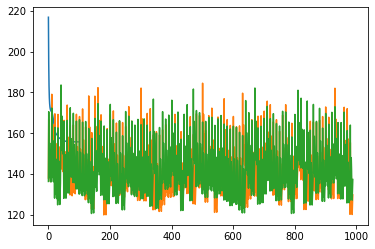

In [ ]:
#sequential learning gaussian process time batches

X_fit = []
for t in range(n):
  X_fit += [tf.Variable(np.random.uniform(size = (n_nodes, d)))]

sd = 0.05
lr = 0.1

save_loss = []
optimizer = tf.optimizers.Adam(learning_rate=lr)

#get initial estimate
t = 0
for step in range(100):
  with tf.GradientTape() as tape:
    nllik = - tf.reduce_sum( tf.math.exp(log_zero_offset) * tfd.Poisson(rate= tf.math.exp(alpha + tf.matmul(X_fit[t], X_fit[t], transpose_b=True) + Z) ).log_prob(Y[ :, :, t]) )
  gradient = tape.gradient(nllik, X_fit[t]) 
  optimizer.apply_gradients(zip([gradient], [X_fit[t]]))
  save_loss += [np.reshape(np.array(nllik), 1)]

plt.plot(save_loss)
nllik_benchmark = - tf.reduce_sum( tf.math.exp(log_zero_offset) * tfd.Poisson(rate= tf.math.exp(alpha + tf.matmul(X_true[:,:,t], X_true[:,:,t], transpose_b=True) + Z) ).log_prob(Y[ :, :, t]) )



save_loss = []
# get trough the entire sequence
for t in range(1, n):
  X_fit[t].assign(X_fit[t-1])
  optimizer = tf.optimizers.Adam(learning_rate=lr)
  for step in range(10):
    with tf.GradientTape() as tape:
      nllik = - tf.reduce_sum( tf.math.exp(log_zero_offset) * tfd.Poisson(rate= tf.math.exp(alpha + tf.matmul(X_fit[t], X_fit[t], transpose_b=True) + Z) ).log_prob(Y[ :, :, t]) ) - tf.reduce_sum( tfd.Normal(loc = X_fit[t-1], scale=sd ).log_prob(X_fit[t]) )
    gradient = tape.gradient(nllik, X_fit[t]) 
    optimizer.apply_gradients(zip([gradient], [X_fit[t]]))
    save_loss += [np.reshape(np.array(nllik), 1)]


plt.plot(save_loss)


save_loss = []
# get trough the sequence backward in time
for t in range(n-2, -1, -1):
  X_fit[t].assign(X_fit[t+1])
  optimizer = tf.optimizers.Adam(learning_rate=lr)
  for step in range(10):
    with tf.GradientTape() as tape:
      nllik = - tf.reduce_sum( tf.math.exp(log_zero_offset) * tfd.Poisson(rate= tf.math.exp(alpha + tf.matmul(X_fit[t], X_fit[t], transpose_b=True) + Z) ).log_prob(Y[ :, :, t]) ) - tf.reduce_sum( tfd.Normal(loc = X_fit[t+1], scale=sd ).log_prob(X_fit[t]) )
    gradient = tape.gradient(nllik, X_fit[t]) 
    optimizer.apply_gradients(zip([gradient], [X_fit[t]]))
    save_loss += [np.reshape(np.array(nllik), 1)]


plt.plot(save_loss)


In [ ]:
# plot results
X_res = np.full((n_nodes, d, n), 0.)
for t in range(n):
  X_res[ :, :, t] = X_fit[t]

similarity_true = np.full((n_nodes, n_nodes, n), 0.)
similarity_fit = np.full((n_nodes, n_nodes, n), 0.)
for t in range(n):
  similarity_true[ :, :, t] = tf.matmul(X_true[:,:,t], X_true[:,:,t], transpose_b=True)
  similarity_fit[ :, :, t] = tf.matmul(X_res[:,:,t], X_res[:,:,t], transpose_b=True)

fig, axs = plt.subplots(n_nodes, n_nodes)
for i in range(n_nodes):
  for j in range(n_nodes):
    axs[ i, j].plot(similarity_true[ i, j, :])
    axs[ i, j].plot(similarity_fit[ i, j, :])




array([[-0.27097586,  0.64722736],
       [ 0.8700507 , -0.72360699],
       [ 0.07953232,  0.01753709],
       [ 0.83207965,  0.05144757],
       [ 0.02523094, -0.41051345],
       [ 0.55773917, -0.39460101],
       [-0.5428069 ,  0.00905759],
       [ 0.44349544, -0.87556719],
       [ 0.90506073, -0.06831975],
       [-0.31848699,  0.1567647 ]])

In [ ]:
#single tensor product likelihood

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import numpy as np
from sklearn.datasets import make_blobs
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import scipy.special
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import time

if tf.config.list_physical_devices('GPU'):
  print("TensorFlow is using the GPU")
else:
  print("TensorFlow is not using the GPU")


d=2
p=10
n=100
n_nodes = 1000
time_interval = np.array(range(1, n+1))
X_true = np.zeros((n, n_nodes, d))
Y = np.zeros((n, n_nodes, n_nodes))

for i in range(n_nodes):
  for j in range(d):
    X_true[ :, i, j] = (tf.keras.activations.sigmoid(np.random.uniform(-2, 2, 1)*10*(time_interval/n-np.random.uniform(0.2, 0.8, 1))) -0.5)*np.random.uniform(1, 3, 1) + np.random.uniform(-0.5, 0.5, 1)
    #plt.plot(X_true[ :, i, j])

#similarity_matrix = tf.matmul(X_true, X_true, transpose_b = True)
#plt.hist(np.reshape(np.std(similarity_matrix, 0), -1))


alpha = tf.constant(3., dtype = tf.float32)
Z = tf.constant(0., dtype = tf.float32)

#Z = np.random.normal(size=(n_nodes, n_nodes), scale=5*alpha)
log_zero_offset = np.zeros((n, n_nodes, n_nodes))
for t in range(n):
  np.fill_diagonal(log_zero_offset[ t, :, :], - np.Inf)

for t in range(n):
  Y[ t, :, :] = np.random.poisson(lam = np.exp(log_zero_offset[t, :, :] + alpha + np.matmul(X_true[ t, :, :], X_true[ t, :, :].T) + Z) , size=(n_nodes, n_nodes))
  #print(np.all(np.matmul(X_true[ t, :, :], X_true[ t, :, :].T) == similarity_matrix[ t, :, :]))

Y = tf.constant(Y)
log_zero_offset = tf.constant(log_zero_offset)

TensorFlow is not using the GPU


In [ ]:
#fit gaussian process no batches

X_fit = tf.Variable(np.random.uniform(-1, 1, (n, n_nodes, d)))

sd = 0.05
lr = 0.01

save_loss = []
#optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer = tf.optimizers.SGD(learning_rate=0.00001)


for step in range(100):
  with tf.GradientTape() as tape:
    nllik = - tf.reduce_sum( tf.math.exp(log_zero_offset) * tfd.Poisson(rate= tf.math.exp(alpha + tf.matmul(X_fit, X_fit, transpose_b=True) + Z) ).log_prob(Y) ) - tf.reduce_sum( tfd.Normal(loc = X_fit[0:(n-1), :, :], scale=sd ).log_prob(X_fit[1:n, :, :]) )
  gradient = tape.gradient(nllik, X_fit) 
  optimizer.apply_gradients(zip([gradient], [X_fit]))
  save_loss += [np.reshape(np.array(nllik), 1)]


plt.plot(save_loss)
plt.plot(tf.math.log(save_loss))


In [ ]:
# model 1: classic matrix multiplication
X_fit = tf.reshape( tf.matmul(basis, model.weights, transpose_b=True), (n, n_nodes, d))
#weights2 = model.weights

# model 2: operations on selected indices only
#X_fit = tf.reshape( tf.matmul(basis, tf.reshape(model.weights, (n_nodes*d, n_basis)), transpose_b=True), (n, n_nodes, d))
#tf.reduce_max(tf.abs(weights2 - tf.reshape(model.weights, (n_nodes*d, n_basis))))


X_true = tf.reshape(X_true, (n, n_nodes, d))
n_plots = 10
i_vec= tf.random.uniform(shape = [n_plots**2], maxval = n_nodes, dtype = tf.int32)
ind = 0
fig, axs = plt.subplots(n_plots, n_plots, figsize=(25,25))
for i in range(n_plots):
  for j in range(n_plots):
    axs[ i, j].plot( tf.reduce_sum(X_true[:, i_vec[ind], :] * X_true[:, i_vec[ind], :], axis=1))
    axs[ i, j].plot(tf.reduce_sum(X_fit[:, i_vec[ind], :] * X_fit[:, i_vec[ind], :], axis=1))
    ind += 1 

X_true = tf.reshape(X_true, (-1, 2))


# similarity_true = tf.matmul(X_true[:, 0:15, :], X_true[:, 0:15, :], transpose_b=True)
# similarity_fit = tf.matmul(X_fit[:, 0:15, :], X_fit[:, 0:15, :], transpose_b=True)
# fig, axs = plt.subplots(15, 15, figsize=(25,25))
# for i in range(15):
#   for j in range(i+1, 15):
#     axs[ i, j].plot(similarity_true[ :, i, j])
#     axs[ i, j].plot(similarity_fit[ :, i, j])

# n_plots = 10
# i_vec= tf.random.uniform(shape = [n_plots**2], maxval = n_nodes, dtype = tf.int32)
# j_vec = tf.random.uniform(shape = [n_plots**2], maxval = n_nodes, dtype = tf.int32)
# ind = 0
# fig, axs = plt.subplots(n_plots, n_plots, figsize=(25,25))
# for i in range(n_plots):
#   for j in range(n_plots):
#     axs[ i, j].plot( tf.reduce_sum(X_true[:, i_vec[ind], :] * X_true[:, j_vec[ind], :], axis=1))
#     axs[ i, j].plot(tf.reduce_sum(X_fit[:, i_vec[ind], :] * X_fit[:, j_vec[ind], :], axis=1))
#     ind += 1 


NameError: ignored

In [ ]:
#Import basis functions and penalties 
from google.colab import files
files.upload()

n_basis = 10
import pandas
df = pandas.read_csv('basis_pspline.csv')
basis = np.array(df)[:, 1:(n_basis+1)] 
basis = tf.constant(basis)

# df = pandas.read_csv('basis_tpspline.csv')
# basis = np.array(df)[:, 1:(n_basis+1)] 
# basis = tf.constant(basis)

#df = pandas.read_csv('penalty.csv')
#penalty = np.array(df)[:, 1:(n_basis+1)] 

plt.plot(basis)

In [ ]:
#fit spline process no batches Gaussian penalty
weights = tf.Variable(np.random.uniform(-1, 1, (n_nodes * d, n_basis)))
#weights = tf.Variable(np.full((n_nodes * d, n_basis), 0.1/n_basis))

sd = 0.05
lr = 0.01


#optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer = tf.optimizers.SGD(learning_rate=0.000001)

save_loss = []
for step in range(100):
  with tf.GradientTape() as tape:
    X_fit = tf.reshape( tf.matmul(basis, weights, transpose_b=True), (n, n_nodes, d))
    nllik = - tf.reduce_sum( tf.math.exp(log_zero_offset) * tfd.Poisson(rate= tf.math.exp(alpha + tf.matmul(X_fit, X_fit, transpose_b=True) + Z) ).log_prob(Y) )# - tf.reduce_sum( tfd.Normal(loc = X_fit[0:(n-1), :, :], scale=sd ).log_prob(X_fit[1:n, :, :]) )
  gradient = tape.gradient(nllik, weights) 
  optimizer.apply_gradients(zip([gradient], [weights]))
  save_loss += [nllik]





plt.plot(save_loss)
plt.plot(tf.math.log(save_loss))





In [ ]:
# make use of tf.function for graph computing

weights = tf.Variable(np.random.uniform(-1, 1, (n_nodes * d, n_basis)))
optimizer = tf.optimizers.SGD(learning_rate=0.0000001)

@tf.function
def training():
  with tf.GradientTape() as tape:
    X_fit = tf.reshape( tf.matmul(basis, weights, transpose_b=True), (n, n_nodes, d))
    nllik = - tf.reduce_sum( tf.math.exp(log_zero_offset) * tfd.Poisson(rate= tf.math.exp(alpha + tf.matmul(X_fit, X_fit, transpose_b=True) + Z) ).log_prob(Y) )# - tf.reduce_sum( tfd.Normal(loc = X_fit[0:(n-1), :, :], scale=sd ).log_prob(X_fit[1:n, :, :]) )
  gradient = tape.gradient(nllik, weights) 
  optimizer.apply_gradients(zip([gradient], [weights]))
  return nllik

#tf.config.run_functions_eagerly(True)
#time_calc = time.time()
#save_loss = []
#for step in range(1000):
#  save_loss += [training()]
#time_calc = time.time() - time_calc
#print(time_calc)


tf.config.run_functions_eagerly(False)
time_calc = time.time()
save_loss = []
for step in range(300):
  save_loss += [training()]
time_calc = time.time() - time_calc
print(time_calc)


plt.plot(save_loss)
plt.figure()
plt.plot(tf.math.log(save_loss))



1000

In [ ]:
#batch optimization

# time, node_1, node_2 = tf.meshgrid(range(n_nodes), range(n_nodes), range(n_nodes))
# data = tf.concat( (tf.reshape(time, (n_nodes**3, 1)), tf.reshape(node_1, (n_nodes**3, 1)), tf.reshape(node_2, (n_nodes**3, 1)) ), axis = 1)
# Y_vector = tf.reshape(Y, -1)
# index_sel =  data[ :, 1] != data[ :, 2]

# data = tf.boolean_mask(data, index_sel) 
# Y_vector = tf.boolean_mask(Y_vector,  index_sel)


# weights = tf.Variable(np.random.uniform(-1, 1, (n_nodes * d, n_basis)))
# optimizer = tf.optimizers.SGD(learning_rate=0.0000001)

# @tf.function
# def training(Y_batch, data_batch):
#   with tf.GradientTape() as tape:
#     X1_fit = tf.reduce_sum(basis[data_batch[0], :] * weights[data_batch[1], :], 1)
#     X2_fit = tf.reduce_sum(basis[data_batch[0], :] * weights[data_batch[2], :], 1)
#     nllik = - tf.reduce_sum( tfd.Poisson(rate= tf.math.exp(alpha + tf.reduce_sum(X1_fit * X2_fit, 1) + Z) ).log_prob(Y_batch) )# - tf.reduce_sum( tfd.Normal(loc = X_fit[0:(n-1), :, :], scale=sd ).log_prob(X_fit[1:n, :, :]) )
#   gradient = tape.gradient(nllik, weights) 
#   optimizer.apply_gradients(zip([gradient], [weights]))
#   return nllik

# #tf.config.run_functions_eagerly(True)
# #time_calc = time.time()
# #save_loss = []
# #for step in range(1000):
# #  save_loss += [training()]
# #time_calc = time.time() - time_calc
# #print(time_calc)


# tf.config.run_functions_eagerly(False)
# time_calc = time.time()
# save_loss = []
# for step in range(300):
#   save_loss += [training()]
# time_calc = time.time() - time_calc
# print(time_calc)


# plt.plot(save_loss)
# plt.figure()
# plt.plot(tf.math.log(save_loss))







In [ ]:
zero_diag = tf.constant(np.full((n, n_nodes), 0. ))

class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.weights = tf.Variable(np.random.uniform(-1, 1, (n_nodes * d, n_basis)))


  def __call__(self, x):
    X_fit = tf.reshape( tf.matmul(basis, self.weights, transpose_b=True), (n, n_nodes, d))
    return alpha + tf.matmul(X_fit, X_fit, transpose_b=True) + Z
     
model = MyModel()

def log_poisson(y_target, linear_predictor):
  return - tf.math.exp(linear_predictor) +  linear_predictor * y_target

def loss(y_target, y_predicted):
  return - tf.reduce_mean( tf.linalg.set_diag( log_poisson(y_target, y_predicted), zero_diag ) )


def train(model, basis, y, learning_rate):
  with tf.GradientTape() as tape:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y, model(basis))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw = tape.gradient(current_loss, model.weights)

  # Subtract the gradient scaled by the learning rate
  model.weights.assign_sub(learning_rate * dw)


model = MyModel()


# Define a training loop
def report(model, loss):
  return f"loss={loss:2.5f}"

loss_save = []
def training_loop(model, x, y):

  for epoch in epochs:
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=10)

    current_loss = loss(y, model(x))
    loss_save.append(current_loss.numpy())
    print(f"Epoch {epoch:2d}:")
    print("    ", report(model, current_loss))

current_loss = loss(Y, model(basis))

print(f"Starting:")
print("    ", report(model, current_loss))

tf.config.run_functions_eagerly(True)
epochs = range(300)
time_calc = time.time()
training_loop(model, basis, Y)
time_calc = time.time() - time_calc
print(time_calc)

plt.plot(loss_save)
plt.figure()
plt.plot(tf.math.log(loss_save))


In [ ]:
# batch half likelihood
index_full = tf.constant(np.empty((0, 2), dtype=np.int32))
start = 0
node_1, node_2 = tf.meshgrid(range(n_nodes), range(n_nodes))
index_batch = tf.concat( ( tf.reshape(node_2, (n_nodes**2, 1)), tf.reshape(node_1, (n_nodes**2, 1)) ), axis = 1)
for t in range(n):
  index_full = tf.concat((index_full, index_batch + start), axis = 0)
  start += n_nodes

Y_vector = tf.reshape(Y, -1)
index_keep =  index_full[ :, 0] != index_full[ :, 1]

index_full = tf.boolean_mask(index_full, index_keep) 
Y_vector = tf.boolean_mask(Y_vector,  index_keep)

index_permutation = np.array(range(len(Y_vector)))
np.random.shuffle(index_permutation)
index_full = tf.gather(index_full, index_permutation)
Y_vector = tf.gather(Y_vector, index_permutation)

batch_size = 1000
train_dataset = tf.data.Dataset.from_tensor_slices((index_full, Y_vector))
#train_dataset = train_dataset.shuffle(buffer_size=len(Y_vector), reshuffle_each_iteration = True).batch(batch_size)
train_dataset = train_dataset.batch(batch_size)


class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.weights = tf.Variable(tf.random.uniform(shape = (n_nodes * d, n_basis) , minval= -1, maxval= 1, dtype=tf.float32))

  def __call__(self, index_batch):
    X_fit = tf.reshape( tf.matmul(basis, self.weights, transpose_b=True), (n * n_nodes, d))
    return alpha + tf.einsum('ij,ij->i', tf.gather(X_fit, index_batch[:, 0], axis=0), tf.gather(X_fit, index_batch[:, 1], axis=0)) + Z
     
model = MyModel()
#for batch_step, (index_batch, y_batch) in enumerate(train_dataset):
#  print(loss(y_batch, model(index_batch)))

#tf.gather(Y_vector, index_full[0:10,0])
#tf.gather(index_full, index_full[0:10,1])


def log_poisson(y_target, linear_predictor):
  return - tf.math.exp(linear_predictor) +  linear_predictor * y_target
 
def loss(y_target, y_predicted):
  return - tf.reduce_mean(log_poisson(y_target, y_predicted))

#def loss(y_target, y_predicted):
#  return - tf.reduce_mean(tfd.Poisson(log_rate= y_predicted ).log_prob(y_target))

def train(model, index_batch, y_batch, optimizer):
  with tf.GradientTape() as tape:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y_batch, model(index_batch))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw = tape.gradient(current_loss, model.weights)

  # Subtract the gradient scaled by the learning rate
  #model.weights.assign_sub(learning_rate * dw)
  optimizer.apply_gradients(zip( [dw], [model.weights]))
  return current_loss


# model = MyModel()
# iter = train_dataset.__iter__()
# index_batch, y_batch = next(iter)
# optimizer = tf.optimizers.SGD(learning_rate=0.00001)
# with tf.GradientTape() as tape:
#   current_loss = loss(y_batch, model(index_batch))
# gradient = tape.gradient(current_loss, model.weights)
# optimizer.apply_gradients(zip( [gradient], model.weights))
# gradient.indices
# gradient.values


# Define a training loop
def report(model, loss):
  return f"loss={loss:2.5f}"

loss_save = []
def training_loop(model, optimizer):
  for epoch in epochs:
    loss_batch = []
    for step_batch, (index_batch, y_batch) in enumerate(train_dataset):
      current_loss = train(model, index_batch, y_batch, optimizer)
      loss_batch.append(current_loss.numpy())
      if((step_batch % 100) == 0):
        loss_tmp = tf.reduce_mean(loss_batch)
        loss_save.append(loss_tmp)  
        print(f"Epoch {epoch:2d}:")
        print("    ", report(model, loss_tmp))
        loss_batch = []
      if(step_batch == max_batch_iter):
        break

tf.random.set_seed(1)
model = MyModel()
optimizer = tf.optimizers.Adam(learning_rate=0.01)
tf.config.run_functions_eagerly(True)
epochs = range(1)
max_batch_iter = 10000
time_calc = time.time()
training_loop(model, optimizer)
time_calc = time.time() - time_calc
print(time_calc)

plt.plot(loss_save)
plt.figure()
plt.plot(tf.math.log(loss_save))

# #iter = train_dataset.__iter__()
# #index_batch1, y_batch1 = next(iter)
# tf.random.set_seed(1)
# weights = tf.Variable(tf.random.uniform(shape = (n_nodes * d, n_basis) , minval= -1, maxval= 1, dtype=tf.float32))
# X_fit = tf.reshape( tf.matmul(basis, weights, transpose_b=True), (n * n_nodes, d))
# save = tf.einsum('ij,ij->i', tf.gather(X_fit, index_batch1[:, 0], axis=0), tf.gather(X_fit, index_batch1[:, 1], axis=0))

# #iter2 = train_dataset.__iter__()
# #index_batch2, y_batch2 = next(iter2)
# tf.random.set_seed(1)
# weights2 = tf.Variable(tf.random.uniform(shape = (n_nodes, n_basis * d) , minval= -1, maxval= 1, dtype=tf.float32))
# time = tf.reshape(tf.gather(double_basis, index_batch2[:, 0]),  (batch_size *d, n_basis))
# w1 = tf.reshape(tf.gather(weights2 * 1 , index_batch2[:, 1]),  (batch_size *d, n_basis))
# w2 = tf.reshape(tf.gather(weights2 * 1, index_batch2[:, 2]),  (batch_size *d, n_basis))
# similarity = tf.einsum('ij,ij->i', tf.reshape(tf.einsum('ij,ij->i', time, w1), (batch_size, d)), tf.reshape(tf.einsum('ij,ij->i', time, w2), (batch_size, d)) )



In [ ]:
#batch decomposition of full likelihood
#double_squared_basis = tf.pow(basis, 2)
#double_squared_basis = tf.concat((basis, basis), axis=1)
double_basis = tf.concat((basis, basis), axis=1)

index_full = tf.constant(np.empty((0, 3), dtype=np.int32))
node_1, node_2 = tf.meshgrid(range(n_nodes), range(n_nodes))
index_batch = tf.concat( ( tf.reshape(node_2, (n_nodes**2, 1)), tf.reshape(node_1, (n_nodes**2, 1)) ), axis = 1)
for t in range(n):
  new_block = tf.concat((tf.constant(t, shape=(n_nodes**2, 1)), index_batch), axis=1)
  index_full = tf.concat((index_full, new_block), axis = 0)


index_keep =  index_full[ :, 1] != index_full[ :, 2]

index_full = tf.boolean_mask(index_full, index_keep) 
Y_vector = tf.reshape(Y, -1)
Y_vector = tf.boolean_mask(Y_vector,  index_keep)

index_permutation = np.array(range(len(Y_vector)))
np.random.shuffle(index_permutation)
index_full = tf.gather(index_full, index_permutation)
Y_vector = tf.gather(Y_vector, index_permutation)

batch_size = 1000
train_dataset = tf.data.Dataset.from_tensor_slices((index_full, Y_vector))
#train_dataset = train_dataset.shuffle(buffer_size=len(Y_vector), reshuffle_each_iteration = True).batch(batch_size)
train_dataset = train_dataset.batch(batch_size)



class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.weights = tf.Variable(tf.random.uniform(shape = (n_nodes, n_basis * d) , minval= -1, maxval= 1, dtype=tf.float32))


  def __call__(self, index_batch):
    time = tf.reshape(tf.gather(double_basis, index_batch[:, 0]),  (batch_size *d, n_basis))
    w1 = tf.reshape(tf.gather(self.weights * 1 , index_batch[:, 1]),  (batch_size *d, n_basis))
    w2 = tf.reshape(tf.gather(self.weights * 1, index_batch[:, 2]),  (batch_size *d, n_basis))
    similarity = tf.einsum('ij,ij->i', tf.reshape(tf.einsum('ij,ij->i', time, w1), (batch_size, d)), tf.reshape(tf.einsum('ij,ij->i', time, w2), (batch_size, d)) )
    return alpha + similarity + Z
     
#model = MyModel()
#for batch_step, (index_batch, y_batch) in enumerate(train_dataset):
#  print(loss(y_batch, model(index_batch)))

#tf.gather(Y_vector, index_full[0:10,0])
#tf.gather(index_full, index_full[0:10,1])


def log_poisson(y_target, linear_predictor):
  return - tf.math.exp(linear_predictor) +  linear_predictor * y_target
 
def loss(y_target, y_predicted):
  return - tf.reduce_mean(log_poisson(y_target, y_predicted))

#def loss(y_target, y_predicted):
#  return - tf.reduce_mean(tfd.Poisson(log_rate= y_predicted ).log_prob(y_target))

def train(model, index_batch, y_batch, optimizer):
  with tf.GradientTape() as tape:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y_batch, model(index_batch))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw = tape.gradient(current_loss, model.weights)

  # Subtract the gradient scaled by the learning rate
  #model.weights.assign_sub( 0.01 * dw )
  optimizer.apply_gradients(zip( [dw], [model.weights]))
  return current_loss


# model = MyModel()
# iter = train_dataset.__iter__()
# index_batch, y_batch = next(iter)
# optimizer = tf.optimizers.SGD(learning_rate=0.00001)
# with tf.GradientTape() as tape:
#   current_loss = loss(y_batch, model(index_batch))
# gradient = tape.gradient(current_loss, model.weights)
# optimizer.apply_gradients(zip( [gradient], model.weights))
# gradient.indices
# gradient.values


# Define a training loop
def report(model, loss):
  return f"loss={loss:2.5f}"

loss_save = []
def training_loop(model, optimizer):
  for epoch in epochs:
    loss_batch = []
    for step_batch, (index_batch, y_batch) in enumerate(train_dataset):
      current_loss = train(model, index_batch, y_batch, optimizer)
      loss_batch.append(current_loss.numpy())
      if((step_batch % 100) == 0):
        loss_tmp = tf.reduce_mean(loss_batch)
        loss_save.append(loss_tmp)  
        print(f"Epoch {epoch:2d}:")
        print("    ", report(model, loss_tmp))
        loss_batch = []
      if(step_batch == max_batch_iter):
        break

tf.random.set_seed(1)
model = MyModel()
optimizer = tf.optimizers.Adam(learning_rate=0.01)
tf.config.run_functions_eagerly(True)
epochs = range(1)
max_batch_iter = 10000
time_calc = time.time()
training_loop(model, optimizer)
time_calc = time.time() - time_calc
print(time_calc)


plt.plot(loss_save)

# tf.random.set_seed(1)
# model = MyModel()
# optimizer = tf.optimizers.Adam(learning_rate=0.01)
# iter = train_dataset.__iter__()
# for i in range(10):
#   index_batch, y_batch = next(iter)
#   print(train(model, index_batch, y_batch, optimizer))

#loss=-10180.67624

TensorFlow is not using GPU computing


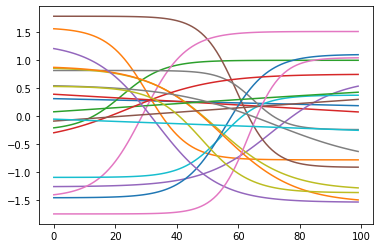

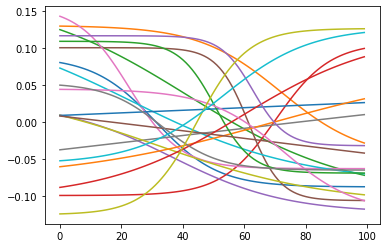

In [1]:
# simulate a clustering dynamics process
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import numpy as np
import pandas as pd
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt


if tf.config.list_physical_devices('GPU'):
  print("TensorFlow is using GPU computing")
else:
  print("TensorFlow is not using GPU computing")


d=tf.constant(2, dtype =tf.int32)
p=tf.constant(10, dtype =tf.int32)
n=tf.constant(100, dtype =tf.int32)
n_nodes = tf.constant(100000, dtype =tf.int32)
time_interval = tf.constant(range(1, n+1), dtype =tf.int32)
X_true_I = np.zeros((n, p, d))
X_true_II = np.zeros((n, p, d))
#X_true = np.zeros((n, n_nodes, d))
alpha = tf.constant(3., dtype = tf.float32)
Z = tf.constant(0., dtype = tf.float32)
cl_I = tf.constant(np.floor(np.random.uniform(0, p, n_nodes)), dtype=tf.int32)
cl_II = tf.constant(np.floor(np.random.uniform(0, p, n_nodes)), dtype=tf.int32)

for i in range(p):
  for j in range(d):
    X_true_I[ :, i, j] = (tf.keras.activations.sigmoid(np.random.uniform(-2, 2, 1)*10*(time_interval/n-np.random.uniform(0.2, 0.8, 1))) -0.5)*np.random.uniform(1, 3, 1) + np.random.uniform(-0.5, 0.5, 1)
    plt.plot(X_true_I[ :, i, j])

plt.figure()
for i in range(p):
  for j in range(d):
    X_true_II[ :, i, j] = (tf.keras.activations.sigmoid(np.random.uniform(-2, 2, 1)*10*(time_interval/n-np.random.uniform(0.2, 0.8, 1))) -0.5)*np.random.uniform(0.1, 0.3, 1) + np.random.uniform(-0.05, 0.05, 1)
    plt.plot(X_true_II[ :, i, j])

X_true_I = tf.constant(X_true_I, dtype=tf.float32)
X_true_I = tf.reshape(X_true_I, (-1, 2))
X_true_II = tf.constant(X_true_II, dtype=tf.float32)
X_true_II = tf.reshape(X_true_II, (-1, 2))

# for i in range(n_nodes):
#   for j in range(d):
#     X_true[ :, i, j] = X_true_cluster[ :, cl_alloc[i], j] + np.random.normal(scale=0.1)

# for i in range(n_nodes):
#   for j in range(d):
#     X_true[ :, i, j] = (tf.keras.activations.sigmoid(np.random.uniform(-2, 2, 1)*10*(time_interval/n-np.random.uniform(0.2, 0.8, 1))) -0.5)*np.random.uniform(1, 3, 1) + np.random.uniform(-0.5, 0.5, 1)

# X_true = tf.constant(X_true)
# X_true = tf.reshape(X_true, (-1, 2))

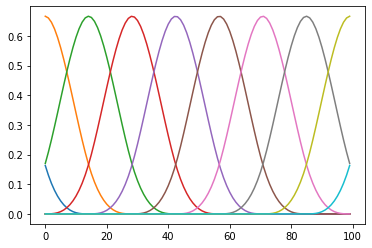

In [3]:
#Import basis functions and penalties from R mgcv
# from google.colab import files
# files.upload()

n_basis = 10
import pandas
# df = pandas.read_csv('basis_pspline.csv')
# basis = np.array(df)[:, 1:(n_basis+1)] 
# basis = tf.constant(basis, dtype=tf.float32)
# plt.plot(basis)

# df = pandas.read_csv('penalty_pspline.csv')
# penalty_mat = np.array(df)[:, 1:(n_basis+1)] 
# penalty_mat = tf.constant(penalty_mat, dtype=tf.float32)

basis = tf.constant(np.load("basis.npy"), dtype=tf.float32)
penalty_mat = tf.constant(np.load("penalty_pspline.npy"), dtype=tf.float32)
plt.plot(basis)



In [ ]:
# index_sparse = tf.constant(np.empty((0, 3), dtype=np.int64))
# Y_vector = tf.constant(np.empty((0), dtype=np.int64))
# for t in range(n):
#   print("processing time {}".format(t))
#   avg_sparsity = []
#   for i in range(n_nodes):
#     similarity = alpha + tf.matmul(tf.reshape(X_true[t, i, :], (1,2)), X_true[t, :, :], transpose_b=True) + Z
#     sample = tf.reshape(tfd.Poisson(log_rate = similarity).sample(1), -1)
#     sample = tf.cast(sample, np.int64)
#     index_j = tf.where(sample != 0)
#     new_block = tf.concat((tf.constant(t, shape=(len(index_j), 1), dtype=np.int64), tf.constant(i, shape=(len(index_j), 1), dtype=np.int64), tf.reshape(index_j, (len(index_j),1))), axis=1)
#     #index_sel =  new_block[ :, 1] != new_block[ :, 2]
#     #new_block = tf.boolean_mask(new_block, index_sel)
#     Y_vector = tf.concat((Y_vector, tf.gather(sample, tf.reshape(index_j, -1))), axis=0 )
#     index_sparse = tf.concat((index_sparse, new_block), axis = 0)
#     avg_sparsity.append(len(index_j)/n_nodes)
#   print("average sparsity level {}".format(tf.reduce_mean(avg_sparsity)))

# batch_size = 10000 # choose a size that fit the memory
# batch_iter = tf.cast(n_nodes/batch_size, np.int64)
# index_sparse = tf.constant(np.empty((0, 3), dtype=np.int64))
# Y_vector = tf.constant(np.empty((0), dtype=np.int64))
# for t in range(n):
#   print("processing time {}".format(t))
#   avg_sparsity = []
#   for i in range(batch_iter):
#     sample = tf.cast(tfd.Poisson(log_rate = alpha + tf.matmul(X_true[t, (batch_size*i):(batch_size*(i+1)) , :], X_true[t, :, :], transpose_b=True) + Z).sample(1), np.int64)
#     index_j = tf.where(sample != 0)
#     sample = tf.boolean_mask(sample, sample != 0)
#     sample = tf.boolean_mask(sample, index_j[ :, 1] != index_j[ :, 2])
#     index_j = tf.boolean_mask(index_j, index_j[ :, 1] != index_j[ :, 2])
#     Y_vector = tf.concat((Y_vector, sample), axis=0 )
#     index_j = tf.concat((tf.constant(t, shape=(len(index_j), 1), dtype=np.int64), tf.reshape(index_j[:, 1] + batch_size*i, (len(index_j),1)), tf.reshape(index_j[:, 2], (len(index_j),1))), axis=1)
#     index_sparse = tf.concat((index_sparse, index_j), axis = 0)
#     avg_sparsity.append(len(index_j)/(n_nodes*batch_size))
#   print("average sparsity level {}".format(tf.reduce_mean(avg_sparsity)))



In [ ]:
double_basis = tf.concat((basis, basis), axis=1)


class MyModel_OLD(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.weights = tf.Variable(tf.random.uniform(shape = (n_nodes * d, n_basis) , minval= -1, maxval= 1, dtype=tf.float32))

  def __call__(self, index_batch):
    X_fit = tf.reshape( tf.matmul(basis, self.weights, transpose_b=True), (n * n_nodes, d))
    return alpha + tf.einsum('ij,ij->i', tf.gather(X_fit, index_batch[:, 0], axis=0), tf.gather(X_fit, index_batch[:, 1], axis=0)) + Z
 
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.weights = tf.Variable(tf.random.uniform(shape = (n_nodes, n_basis * d) , minval= -1, maxval= 1, dtype=tf.float32))


  def __call__(self, index_batch):
    time = tf.reshape(tf.gather(double_basis, index_batch[:, 0]),  (batch_size * d, n_basis))
    w1 = tf.reshape(tf.gather(self.weights * 1 , index_batch[:, 1]),  (batch_size * d, n_basis))
    w2 = tf.reshape(tf.gather(self.weights * 1, index_batch[:, 2]),  (batch_size * d, n_basis))
    similarity = tf.einsum('ij,ij->i', tf.reshape(tf.einsum('ij,ij->i', time, w1), (batch_size, d)), tf.reshape(tf.einsum('ij,ij->i', time, w2), (batch_size, d)) )
    return alpha + similarity + Z

def log_poisson(y_target, linear_predictor):
  return - tf.math.exp(linear_predictor) +  linear_predictor * y_target
 
def loss(y_target, y_predicted):
  return - tf.reduce_mean(log_poisson(y_target, y_predicted))


def train(model, index_batch, y_batch, optimizer):
  with tf.GradientTape() as tape:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y_batch, model(index_batch))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw = tape.gradient(current_loss, model.weights)

  # Subtract the gradient scaled by the learning rate
  #model.weights.assign_sub(learning_rate * dw)
  optimizer.apply_gradients(zip( [dw], [model.weights]))
  return current_loss



# Define a training loop
def report(model, loss):
  return f"loss={loss:2.5f}"

loss_save = []
def training_loop(model, optimizer):
  loss_batch = []
  for step_batch, (index_batch, y_batch) in enumerate(train_dataset):
    current_loss = train(model, index_batch, y_batch, optimizer)
    loss_batch.append(current_loss.numpy())
    if(((step_batch % 100) == 0) & (step_batch!=0)):
      loss_tmp = tf.reduce_mean(loss_batch)
      loss_save.append(loss_tmp)  
      #print(f"Batch {step_batch:2d}:")
      print("    ", report(model, loss_tmp))
      loss_batch = []


def generator():
  t = tf.random.uniform(shape = [batch_size], maxval = n, dtype = tf.int32)
  i = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
  j = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
  if(tf.reduce_any(i==j)): 
    j = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
  X_fit_1 = tf.gather(X_true, t*n_nodes + i )
  X_fit_2 = tf.gather(X_true, t*n_nodes + j )
  sample = tfd.Poisson(log_rate = alpha + tf.einsum('ij,ij->i', X_fit_1, X_fit_2) + Z).sample(1)
  #res_index = tf.concat((t*n_nodes + i, t*n_nodes + j), axis=1)
  yield tf.stack((t, i, j), axis=1), tf.reshape(sample, -1)


full_size = 50000000
batch_size = 100000

train_dataset = tf.data.Dataset.from_tensor_slices(generator(full_size, n, n_nodes, X_true, alpha, Z))
train_dataset = train_dataset.batch(batch_size)


train_dataset = tf.data.Dataset.from_tensor_slices(generator(full_size, n, n_nodes, X_true, alpha, Z, old_method=True))
train_dataset = train_dataset.batch(batch_size)


train_dataset = tf.data.Dataset.from_generator(
     generator,
     output_signature=(
         tf.TensorSpec(shape=(None, 3), dtype=tf.int32),
         tf.TensorSpec(shape=(None, ), dtype=tf.float32)))

train_dataset = train_dataset.repeat().take(10000)

model = MyModel()
# model = MyModel_OLD()
optimizer = tf.optimizers.Adam(learning_rate=0.01)

tf.config.run_functions_eagerly(False)
time_calc = time.time()
training_loop(model, optimizer)
time_calc = time.time() - time_calc
print(time_calc)


plt.plot(loss_save)

a=list(generator())


train_dataset = train_dataset.repeat().take(2)
for i, (x, y) in enumerate(train_dataset):
  print(i)
  print(x)
  print(y)

In [ ]:
#model with penalty

def get_penalty_smooth(weights):
  return tf.einsum('ij,ij->', tf.matmul(weights, penalty_mat), weights)

# def get_penalty_linkage(index_batch_modified, weights_reshaped, centroid_weights_reshaped):
#   index_total = tf.concat([tf.gather(index_batch_modified, 0, axis=1), tf.gather(index_batch_modified, 1, axis=1)], axis=0)
#   return tf.reduce_mean((tf.reduce_sum(tf.square(tf.subtract(tf.gather(weights_reshaped, index_total), tf.gather(centroid_weights_reshaped, index_total))), axis=1), 2))

# def get_penalty_clust(index_batch_modified, weights_reshaped, centroid_weights_reshaped, gamma_clust_weight):
#   w = tf.stop_gradient( tf.math.exp( tf.scalar_mul(gamma_clust_weight, tf.math.negative(tf.reduce_sum(tf.square(tf.math.subtract( tf.gather(weights_reshaped, tf.gather(index_batch_modified, 0, axis=1), axis=0), tf.gather(weights_reshaped, tf.gather(index_batch_modified, 1, axis=1), axis=0) )), axis=1))  )))
#   return tf.einsum('i,i->', w, (tf.reduce_sum( tf.square( tf.math.subtract( tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 0, axis=1), axis=0), tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 1, axis=1), axis=0) )), axis=1)))
#   #return tf.reduce_mean(tf.sqrt(tf.reduce_sum( tf.square( tf.subtract( tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 0, axis=1), axis=0), tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 1, axis=1), axis=0) )), axis=1)))

def get_penalty_clust(index_batch_modified, weights_reshaped, centroid_weights_reshaped, gamma_convex_clust, gamma_kernel_clust):
  w = tf.stop_gradient( tf.math.exp( tf.scalar_mul(gamma_kernel_clust, tf.math.negative(tf.reduce_sum(tf.square(tf.math.subtract( tf.gather(weights_reshaped, tf.gather(index_batch_modified, 0, axis=1), axis=0), tf.gather(weights_reshaped, tf.gather(index_batch_modified, 1, axis=1), axis=0) )), axis=1))  )))
  index_total = tf.concat([tf.gather(index_batch_modified, 0, axis=1), tf.gather(index_batch_modified, 1, axis=1)], axis=0)
  gaussian_linkage = tf.reduce_sum(tf.square(tf.subtract(tf.gather(weights_reshaped, index_total), tf.gather(centroid_weights_reshaped, index_total))), axis=1)
  gaussian_linkage = tf.einsum('i,i->', tf.concat([w, w], axis=0), gaussian_linkage)
  distance_penalty = tf.einsum('i,i->', w, (tf.reduce_sum( tf.square( tf.math.subtract( tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 0, axis=1), axis=0), tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 1, axis=1), axis=0) )), axis=1)))
  return tf.math.add(gaussian_linkage, tf.scalar_mul(gamma_convex_clust, distance_penalty))



class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.weights = tf.Variable(tf.random.uniform(shape = (n_nodes * d, n_basis) , minval= -1, maxval= 1, dtype=tf.float32))
    self.centroid_weights = tf.Variable(tf.random.uniform(shape = (n_nodes * d, n_basis) , minval= -1, maxval= 1, dtype=tf.float32))
    self.Lambda = tf.Variable(0,  dtype=tf.float32)

  def __call__(self, index_batch):
    X_fit = tf.reshape( tf.matmul(basis, self.weights, transpose_b=True), (n * n_nodes, d))
    X_fit_1 = tf.gather(X_fit, tf.gather(index_batch, 0, axis=1), axis=0)
    X_fit_2 = tf.gather(X_fit, tf.gather(index_batch, 1, axis=1), axis=0)
    similarity = tf.scalar_mul(tf.math.exp(self.Lambda), tf.einsum('ij,ij->i', X_fit_1, X_fit_2))
    penalty_sphere = tf.reduce_mean(tf.square(tf.reduce_sum(tf.square(tf.concat([X_fit_1, X_fit_2], axis=0)) - 1/d, axis=1)))
    return tf.math.add(alpha, similarity), penalty_sphere

  # def __call__(self, index_batch):
  #   X_fit = tf.reshape( tf.matmul(basis, self.weights, transpose_b=True), (n * n_nodes, d))
  #   similarity = tf.scalar_mul(tf.math.exp(self.Lambda), tf.einsum('ij,ij->i', tf.gather(X_fit, tf.gather(index_batch, 0, axis=1), axis=0), tf.gather(X_fit, tf.gather(index_batch, 1, axis=1), axis=0)))
  #   penalty_sphere = 0
  #   return tf.math.add(alpha, similarity), penalty_sphere
 

 
#double_basis = tf.concat((basis, basis), axis=1)
# class MyModel(tf.Module):
#   def __init__(self, **kwargs):
#     super().__init__(**kwargs)
#     self.weights = tf.Variable(tf.random.uniform(shape = (n_nodes, n_basis * d) , minval= -1, maxval= 1, dtype=tf.float32))


#   def __call__(self, index_batch):
#     time = tf.reshape(tf.gather(double_basis, index_batch[:, 0]),  (batch_size *d, n_basis))
#     w1 = tf.reshape(tf.gather(self.weights * 1 , index_batch[:, 1]),  (batch_size *d, n_basis))
#     w2 = tf.reshape(tf.gather(self.weights * 1, index_batch[:, 2]),  (batch_size *d, n_basis))
#     similarity = tf.einsum('ij,ij->i', tf.reshape(tf.einsum('ij,ij->i', time, w1), (batch_size, d)), tf.reshape(tf.einsum('ij,ij->i', time, w2), (batch_size, d)) )
#     return alpha + similarity + Z

def log_poisson(y_target, linear_predictor):
  return  tf.math.add(tf.math.negative(tf.math.exp(linear_predictor)), tf.math.multiply(linear_predictor, y_target))
 
def loss(y_target, y_predicted, gamma_sphere):
  y_predicted, penalty_sphere = y_predicted
  return tf.math.negative(tf.reduce_mean(log_poisson(y_target, y_predicted))) + gamma_sphere * penalty_sphere, penalty_sphere


def train(model, index_batch, y_batch, optimizer, hyper_params):
  gamma_smooth, gamma_linkage, gamma_convex_clust, gamma_kernel_clust, gamma_sphere = hyper_params
  with tf.GradientTape() as tape:
    current_loss, sphere_loss = loss(y_batch, model(index_batch), gamma_sphere)
    penalized_loss = tf.math.add( current_loss, tf.math.multiply(gamma_smooth, get_penalty_smooth(model.weights)) )
    convex_clustering_loss = tf.math.multiply(gamma_linkage, get_penalty_clust(tf.math.floormod(index_batch, n_nodes), tf.reshape(tf.math.scalar_mul(1, model.weights), (n_nodes, n_basis*d)), tf.reshape(tf.math.scalar_mul(1, model.centroid_weights), (n_nodes, n_basis*d)), gamma_convex_clust, gamma_kernel_clust))
    penalized_loss += convex_clustering_loss
    # penalized_loss = current_loss
    # convex_clustering_loss = 0
  dw = tape.gradient(penalized_loss, model.variables)
  optimizer.apply_gradients(zip( dw, model.variables))
  return current_loss, convex_clustering_loss, sphere_loss



loss_batch = tf.Variable(np.Inf, dtype = tf.float32)
convex_clustering_loss_batch = tf.Variable(np.Inf, dtype = tf.float32)
@tf.function
def training_loop(model, optimizer, hyper_params, print_freq):
  for step_batch, (index_batch, y_batch) in enumerate(train_dataset):
    current_loss, convex_clustering_loss, sphere_loss = train(model, index_batch, y_batch, optimizer, hyper_params)
    #print(current_loss)
    loss_batch.assign(tf.reduce_min([current_loss, loss_batch]))
    convex_clustering_loss_batch.assign(tf.reduce_min([convex_clustering_loss, convex_clustering_loss_batch]))
    if(((step_batch % print_freq) == 0) & (step_batch!=0)):
      tf.print("processed batches=", step_batch, "  min out_of_fold loss=", loss_batch, "  min convex_clustering_loss=", convex_clustering_loss_batch, "sphere loss", sphere_loss)



def generator():
  t = tf.random.uniform(shape = [batch_size], maxval = n, dtype = tf.int32)
  i = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
  j = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
  while tf.reduce_any(i==j):
    j = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
  #res_index = tf.stack((t, i, j), axis=1)
  #sample = tfd.Poisson(log_rate = tf.math.add(alpha, tf.einsum('ij,ij->i', tf.gather(X_true, tf.gather(res_index, 0, axis=1), axis=0 ), tf.gather(X_true, tf.gather(res_index, 1, axis=1), axis=0 ))) ).sample(1)
  X_true_1 = tf.gather(X_true_I, tf.math.scalar_mul(p, t) + tf.gather(cl_I, i)) + tf.gather(X_true_II, tf.math.scalar_mul(p, t) + tf.gather(cl_II, i))
  X_true_2 = tf.gather(X_true_I, tf.math.scalar_mul(p, t) + tf.gather(cl_I, j)) + tf.gather(X_true_II, tf.math.scalar_mul(p, t) + tf.gather(cl_II, j))
  res_index = tf.stack(( tf.math.add(tf.math.scalar_mul(n_nodes, t), i), tf.math.add(tf.math.scalar_mul(n_nodes, t), j)), axis=1)
  sample = tfd.Poisson(log_rate = tf.math.add(alpha, tf.einsum('ij,ij->i', X_true_1, X_true_2)) ).sample(1)
  yield res_index, tf.reshape(sample, -1)


batch_size = n_nodes

train_dataset = tf.data.Dataset.from_generator(
     generator,
     output_signature=(
         tf.TensorSpec(shape=(None, 2), dtype=tf.int32),
         tf.TensorSpec(shape=(None, ), dtype=tf.float32)))


train_dataset = train_dataset.repeat().take(1000)

model = MyModel()
# model = MyModel_OLD()
optimizer = tf.optimizers.Adam(learning_rate=0.01)
gamma_smooth = tf.constant(0.00001, dtype= tf.float32)
gamma_linkage = tf.constant(0, dtype= tf.float32) #0.000001
gamma_convex_clust = tf.constant(30, dtype= tf.float32) 
gamma_kernel_clust = tf.constant(0.5/(tf.cast(n_basis*d, dtype = tf.float32)*(0.1**2)), dtype= tf.float32) 
gamma_sphere = tf.constant(0, dtype= tf.float32)

#tf.config.run_functions_eagerly(False)
training_loop(model, optimizer, (gamma_smooth, gamma_linkage, gamma_convex_clust, gamma_kernel_clust, gamma_sphere), 10)


#weights_save = model.weights
#model.weights.assign(weights_save)
#model.centroid_weights.assign(weights_save)


#model.centroid_weights.assign(model.weights)

processed batches= 10   min out_of_fold loss= -99.682628220134319   min convex_clustering_loss= 0 sphere loss 0.5463993372320024
processed batches= 20   min out_of_fold loss= -99.773898278974613   min convex_clustering_loss= 0 sphere loss 0.5673270068952303
processed batches= 30   min out_of_fold loss= -99.824903995792667   min convex_clustering_loss= 0 sphere loss 0.5865885921367926
processed batches= 40   min out_of_fold loss= -99.90605789883594   min convex_clustering_loss= 0 sphere loss 0.60470209240416506
processed batches= 50   min out_of_fold loss= -99.90605789883594   min convex_clustering_loss= 0 sphere loss 0.62014426467068318
processed batches= 60   min out_of_fold loss= -99.934592961494943   min convex_clustering_loss= 0 sphere loss 0.63449803012416861
processed batches= 70   min out_of_fold loss= -99.934592961494943   min convex_clustering_loss= 0 sphere loss 0.64681745415259129
processed batches= 80   min out_of_fold loss= -100.29816296708914   min convex_clustering_loss=

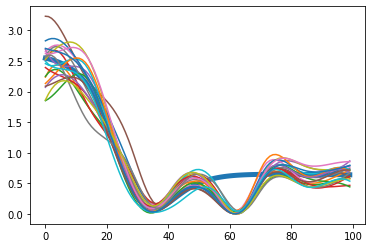

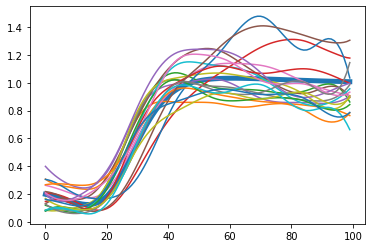

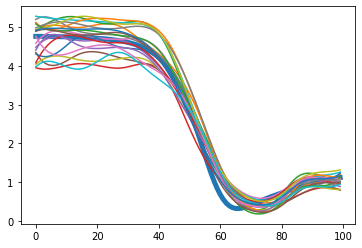

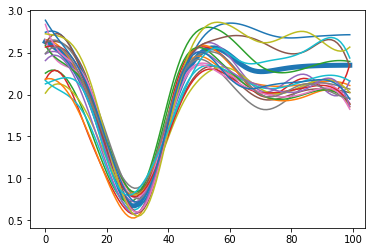

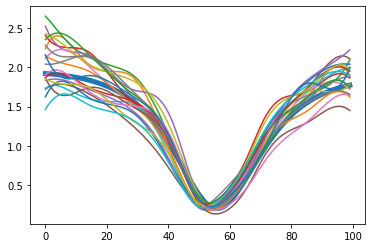

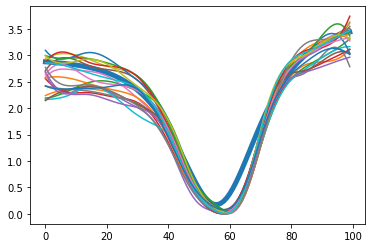

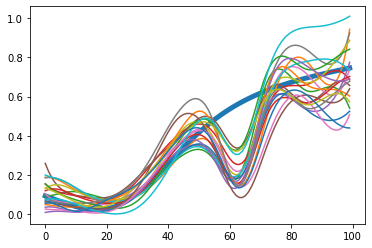

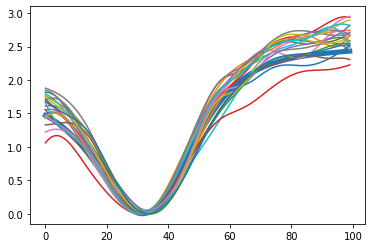

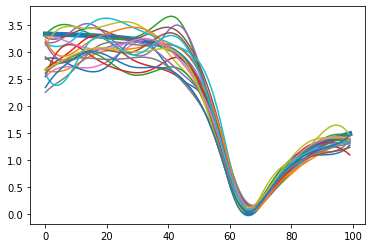

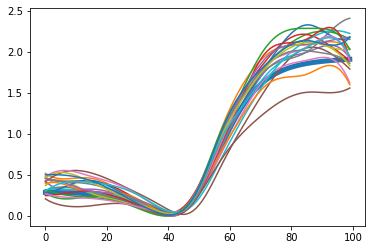

In [41]:
# plot results
#X_fit = tf.reshape( tf.matmul(basis, tf.reshape(tf.split(model.weights, 2, axis=1)[0], (n_nodes*d, n_basis)), transpose_b=True), (n, n_nodes, d))
X_fit = tf.reshape( tf.matmul(basis, tf.reshape(model.weights, (n_nodes*d, n_basis)), transpose_b=True), (n, n_nodes, d))
X_true_I = tf.reshape(X_true_I, (n, p, d))
X_true_II = tf.reshape(X_true_II, (n, p, d))

n_plots = 10
i_vec= tf.random.uniform(shape = [n_plots**2], maxval = n_nodes, dtype = tf.int32)
ind = 0
fig, axs = plt.subplots(n_plots, n_plots, figsize=(25,25))
for i in range(n_plots):
  for j in range(n_plots):
    X_true_1 = X_true_I[:, cl_I[i_vec[ind]], :] + X_true_II[:, cl_II[i_vec[ind]], :]
    axs[ i, j].plot( tf.reduce_sum(X_true_1 * X_true_1, axis=1))
    axs[ i, j].plot( tf.reduce_sum(X_fit[:, i_vec[ind], :] * X_fit[:, i_vec[ind], :], axis=1))
    ind += 1 

X_true_I = tf.reshape(X_true_I, (-1, 2))
X_true_II = tf.reshape(X_true_II, (-1, 2))


X_fit = tf.reshape( tf.matmul(basis, tf.reshape(model.weights, (n_nodes*d, n_basis)), transpose_b=True), (n, n_nodes, d))
X_true_I = tf.reshape(X_true_I, (n, p, d))
X_true_II = tf.reshape(X_true_II, (n, p, d))

n_plots = p
n_nodes_sample = 20
for i in range(p):
  plt.figure()
  X_true_1 = X_true_I[:, i, :] 
  plt.plot( tf.reduce_sum(X_true_1 * X_true_1, axis=1), linewidth=5)
  a = tf.reshape(tf.where(cl_I==i), -1)
  a = tf.gather(a, tf.random.uniform(shape = [n_nodes_sample], maxval = len(a), dtype = tf.int32))
  for j in range(n_nodes_sample):
    plt.plot(tf.reduce_sum( X_fit[:, a[j], :] * X_fit[:, a[j], :], axis=1))

X_true_I = tf.reshape(X_true_I, (-1, 2))
X_true_II = tf.reshape(X_true_II, (-1, 2))


X_fit = tf.reshape( tf.matmul(basis, tf.reshape(model.centroid_weights, (n_nodes*d, n_basis)), transpose_b=True), (n, n_nodes, d))
X_true_I = tf.reshape(X_true_I, (n, p, d))
X_true_II = tf.reshape(X_true_II, (n, p, d))

n_plots = p
n_nodes_sample = 20
for i in range(p):
  plt.figure()
  X_true_1 = X_true_I[:, i, :] 
  plt.plot( tf.reduce_sum(X_true_1 * X_true_1, axis=1), linewidth=5)
  a = tf.reshape(tf.where(cl_I==i), -1)
  a = tf.gather(a, tf.random.uniform(shape = [n_nodes_sample], maxval = len(a), dtype = tf.int32))
  for j in range(n_nodes_sample):
    plt.plot(tf.reduce_sum( X_fit[:, a[j], :] * X_fit[:, a[j], :], axis=1))

X_true_I = tf.reshape(X_true_I, (-1, 2))
X_true_II = tf.reshape(X_true_II, (-1, 2))


X_fit = tf.reshape( tf.matmul(basis, tf.reshape(model.weights, (n_nodes*d, n_basis)), transpose_b=True), (n, n_nodes, d))
n_plots = 10
i_vec= tf.random.uniform(shape = [n_plots**2], maxval = n_nodes, dtype = tf.int32)
ind = 0
fig, axs = plt.subplots(n_plots, n_plots, figsize=(25,25))
for i in range(n_plots):
  for j in range(n_plots):
    axs[ i, j].plot( tf.reduce_sum(X_true_I[:, i_vec[ind], :]  * X_true_I[:, i_vec[ind], :] , axis=1))
    axs[ i, j].plot( tf.reduce_sum(X_fit[:, i_vec[ind], :] * X_fit[:, i_vec[ind], :], axis=1))
    ind += 1 


from scipy.spatial import distance_matrix
import seaborn as sn
a_ind = []
for i in range(p):
  a = tf.reshape(tf.where(cl_alloc==i), -1)
  a = tf.gather(a, tf.random.uniform(shape = [n_nodes_sample], maxval = len(a), dtype = tf.int32))
  a_ind += list(a.numpy())

a_ind = tf.constant(a_ind, dtype = tf.int32)
centroid_weights_reshaped = tf.gather(tf.reshape(model.centroid_weights, (n_nodes, n_basis*d)), a_ind)
dist = distance_matrix(centroid_weights_reshaped, centroid_weights_reshaped)
wh = tf.where(dist<0.01)
dist = np.zeros((n_nodes_sample*p, n_nodes_sample*p))
dist[wh[:,0], wh[:,1]]  =  1
plt.figure(figsize = (10,7))
sn.heatmap(dist)

weights_reshaped = tf.gather(tf.reshape(model.weights, (n_nodes, n_basis*d)), a_ind)
dist = distance_matrix(weights_reshaped, weights_reshaped)
plt.figure(figsize = (10,7))
sn.heatmap(dist)


gamma_clust_grid = tf.constant([ 0.09, 0.08, 0.07], dtype= tf.float32)
centroid_weights_reshaped_list = []
for g in range(len(gamma_clust_grid)):
  gamma_clust = tf.constant(gamma_clust_grid[g], dtype= tf.float32)
  training_loop(model, optimizer, (gamma_smooth, gamma_linkage, gamma_clust, gamma_clust_weight), 10)
  a_ind = []
  for i in range(p):
    a = tf.reshape(tf.where(cl_alloc==i), -1)
    a = tf.gather(a, tf.random.uniform(shape = [n_nodes_sample], maxval = len(a), dtype = tf.int32))
    a_ind += list(a.numpy())
  a_ind = tf.constant(a_ind, dtype = tf.int32)
  centroid_weights_reshaped_list.append(tf.gather(tf.reshape(model.centroid_weights, (n_nodes, n_basis*d)), a_ind) )

for g in range(len(centroid_weights_reshaped_list)):
  dist = distance_matrix(centroid_weights_reshaped_list[g], centroid_weights_reshaped_list[g])
  plt.figure(figsize = (10,7))
  sn.heatmap(np.log(dist))


plt.figure()
for t in range(100):
  #plt.scatter(X_true_I[ t, :, 0], X_true_I[ t, :, 1], c=[,1,2,3,4,5,6,7,8,9])
  if((t>=60) & (t<=65)):
    plt.scatter(X_true_I[ t, :, 0], X_true_I[ t, :, 1], c="red")
  else:
    plt.scatter(X_true_I[ t, :, 0], X_true_I[ t, :, 1], c=[0,1,2,3,4,5,6,7,8,9])

plt.figure()
for t in range(100):
  #plt.scatter(X_true_I[ t, :, 0], X_true_I[ t, :, 1], c=[,1,2,3,4,5,6,7,8,9])
  if((t>=60) & (t<=65)):
    plt.scatter(X_true_I[ t, 0, 0], X_true_I[ t, 0, 1], c="red")
    plt.scatter(X_true_I[ t, 6, 0], X_true_I[ t, 6, 1], c="red")
  else:
    plt.scatter(X_true_I[ t, 0, 0], X_true_I[ t, 0, 1], c=[0])
    plt.scatter(X_true_I[ t, 6, 0], X_true_I[ t, 6, 1], c=[1])

  plt.scatter(X_true_I[ t, 0, 0], X_true_I[ t, 0, 1])
  plt.scatter(X_true_I[ t, 6, 0], X_true_I[ t, 6, 1])


X_true_I[ 60, 0, 0], X_true_I[ 60, 0, 1], X_true_I[ 60, 6, 0], X_true_I[ 60, 6, 1]




In [ ]:
a=list(generator())

model = MyModel()
train_dataset = train_dataset.repeat().take(1)
for i, (index_batch, y_batch) in enumerate(train_dataset):
  print("yee")
  with tf.GradientTape() as tape:
    a=tf.gather(tf.reshape( 1 * model.weights, (n_nodes, n_basis*d)), tf.math.floormod(index_batch[:,0], n_nodes), axis=0)
    b=tf.gather(tf.reshape(1 * model.weights, (n_nodes, n_basis*d)), tf.math.floormod(index_batch[:,1], n_nodes), axis=0)
    penalty_clust = tf.sqrt(tf.reduce_sum(tf.math.pow( tf.math.subtract(a, b) ,2), axis=1))
    #penalty_clust = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.math.pow( tf.math.subtract(a, b) ,2), axis=1)))
  dw = tape.gradient(penalty_clust, model.weights)
  print(tf.reduce_max(dw))


  #model.weights.assign_sub(learning_rate * dw)
  optimizer.apply_gradients(zip( [dw], [model.weights]))

tf.reduce_min(a)

a = tf.constant([[1,2], [3,4], [5,6]], dtype=tf.float32)
tf.concat([a,a], axis=0)
b=tf.concat([a,a], axis=1)
tf.gather(b, [2,3], axis=1)
c, d = tf.split(b, 2, axis=1)
c = tf.concat([b,b], axis=0)
tf.gather(c, tf.cast(tf.reshape(tf.gather(b, [0, 2], axis=1), -1), tf.int32), axis=0)
tf.scalar_mul(tf.scalar(model.Lambda), a)
tf.matmul(3, a)
tf.matmul(a, 3)
tf.concat([a,a], axis=0)
tf.reduce_sum(a, axis=0)
b = tf.constant([[3,6], [4,2], [6,2]])
tf.einsum("ij, ij->", *(a, a))
tf.reduce_sum(a*b)
a=tf.constant([1,2,3,4])
y, idx = tf.unique(tf.concat([a,a], axis=0))
tf.einsum('i,i->',a, a)
a.shape
tf.strided_slice(tf.transpose(a), [0], [2])
tf.gather(a, 1, axis=1)
step_batch=2
tf.pow(a, 2)
tf.reduce_sum(a)

a = tf.constant(2)
b = tf.constant(3)
tf.math.multiply(a,b)
tf.math.add_n([a,b,a])

# n_nodes=12
# t=15
# i=3

# tf.math.add((n_nodes* t), i)
# tf.math.floormod(183, n_nodes)
# tf.reduce_sum(a, axis=1)
tf.sqrt(tf.constant(0, dtype=tf.float32))
tf.reduce_min(dw)

tf.where(tf.math.floormod(index_batch[:,0], n_nodes) == tf.math.floormod(index_batch[:,1], n_nodes))
tf.where(tf.math.is_nan(dw))



<tf.Tensor: shape=(6, 2), dtype=float64, numpy=
array([[1., 2.],
       [3., 4.],
       [5., 6.],
       [1., 2.],
       [3., 4.],
       [5., 6.]])>

In [ ]:
# objectives:
# DONE:generate data with hierarchies and take it to a million and test whether our solution vs the old one is more performing
# UNFEASIBLE: solve the hierarchical clustering with one only hyperparameter and enhance better solution by using a thresholding kernel (eponential or stepwise?)
# kullbdack liebler hyperparamter optimization( easy just take the gradient in the batch loglik wrt the hyperparameters)
# check if spherical mapping behaves properly (how??)
# add lambda parameter at the quadratic form for stochastic block modeling form
# make exponential model, with integration 



# a sparse gradient update problem
# enforce the density of the gradient by sampling n_nodes edges
# for the clustering enforce density by repeatedy sample n_nodes splines from the history
# smoothness penalty plays with this as you don't update all time points but just one, thats why you need a global penalty

In [16]:
# model optimized for 1e06 !!!

# def get_kernel_w_v2(fixed_weights_1,fixed_weights_2, gamma_kernel_clust):
#   return tf.stop_gradient( tf.math.exp( tf.scalar_mul(gamma_kernel_clust, tf.math.negative(tf.reduce_sum(tf.square(tf.math.subtract( fixed_weights_1, fixed_weights_2 )), axis=1))  )))

# def get_penalty_linkage_v2(weights_1, centroid_weights_1, weights_2, centroid_weights_2):
#   gaussian_linkage = tf.reduce_sum(tf.square(tf.subtract(weights_1, centroid_weights_1)), axis=1)
#   return tf.add(gaussian_linkage, tf.reduce_sum(tf.square(tf.subtract(weights_2, centroid_weights_2)), axis=1) )

# def get_penalty_distance_v2(centroid_weights_1, centroid_weights_2):
#   return tf.reduce_sum( tf.square( tf.math.subtract( centroid_weights_1, centroid_weights_2 )), axis=1)

# def get_latent_variables(index_batch, weights, basis):
#     time = tf.reshape(tf.gather(basis, tf.gather(index_batch, 0, axis=1)), (batch_size, 1, n_basis))
#     return tf.squeeze(tf.matmul(time, tf.reshape(tf.gather(weights, tf.gather(index_batch, 1, axis=1), axis=0), (batch_size, d, n_basis)), transpose_b=True)), tf.squeeze(tf.matmul(time, tf.reshape(tf.gather(weights, tf.gather(index_batch, 2, axis=1), axis=0), (batch_size, d, n_basis)), transpose_b=True))


def get_penalty_l2(weights) :
  return tf.reduce_mean(tf.square(weights))


def get_penalty_smooth(weights, penalty_mat):
  return tf.einsum('ij,ij->', tf.matmul(weights, penalty_mat), weights)

def get_penalty_sphere(X_fit_1, X_fit_2):
  a = tf.reduce_mean(tf.square(tf.reduce_sum(tf.square(X_fit_1) - 1/d, axis=1)))
  return tf.add(a, tf.reduce_mean(tf.square(tf.reduce_sum(tf.square(X_fit_2) - 1/d, axis=1))) )/2

def get_kernel_w(index_batch, weights_fixed, gamma_kernel_sd):
  precision = 1/(2*tf.cast(d*n_basis, dtype = tf.float32)*tf.square(gamma_kernel_sd))
  w = tf.math.exp( tf.scalar_mul(precision, tf.math.negative(tf.reduce_sum(tf.square(tf.math.subtract( tf.gather(weights_fixed, tf.gather(index_batch, 1, axis=1), axis=0), tf.gather(weights_fixed, tf.gather(index_batch, 2, axis=1), axis=0) )), axis=1))  ))
  #wh = tf.squeeze(tf.where(w > threshold))
  return w #tf.gather(w, wh), wh

def get_penalty_linkage(index_batch, weights, centroid_weights):
  gaussian_linkage = tf.reduce_sum(tf.square(tf.subtract(tf.gather(weights, tf.gather(index_batch, 1, axis=1)), tf.gather(centroid_weights, tf.gather(index_batch, 1, axis=1)))), axis=1)
  return tf.add(gaussian_linkage, tf.reduce_sum(tf.square(tf.subtract(tf.gather(weights, tf.gather(index_batch, 2, axis=1)), tf.gather(centroid_weights, tf.gather(index_batch, 2, axis=1)))), axis=1))

def get_penalty_distance(index_batch, centroid_weights):
  return tf.reduce_sum( tf.square( tf.math.subtract( tf.gather(centroid_weights, tf.gather(index_batch, 1, axis=1), axis=0), tf.gather(centroid_weights, tf.gather(index_batch, 2, axis=1), axis=0) )), axis=1)




def get_kernel_w_v3(index_batch, weights_fixed, gamma_kernel_sd):
  w = tf.math.sqrt(tf.reduce_sum(tf.square( tf.gather(weights_fixed, tf.gather(index_batch, 1, axis=1), axis=0) - tf.gather(weights_fixed, tf.gather(index_batch, 2, axis=1), axis=0) ), axis=1))
  # w = tf.cast(tf.math.greater(gamma_kernel_sd, w), tf.float32)
  wh = tf.squeeze(tf.where(tf.math.greater(gamma_kernel_sd, w)))
  return wh

def get_penalty_linkage_v3(weights, centroid_weights):
  return tf.reduce_sum(tf.square(weights - centroid_weights), axis=1)

def get_penalty_distance_v3(index_batch, centroid_weights):
  return tf.math.sqrt(tf.reduce_sum( tf.square( tf.gather(centroid_weights, tf.gather(index_batch, 1, axis=1), axis=0) - tf.gather(centroid_weights, tf.gather(index_batch, 2, axis=1), axis=0) ), axis=1))





# def get_penalty_linkage(index_batch_modified, weights_reshaped, centroid_weights_reshaped):
#   index_total = tf.concat([tf.gather(index_batch_modified, 0, axis=1), tf.gather(index_batch_modified, 1, axis=1)], axis=0)
#   return tf.reduce_mean((tf.reduce_sum(tf.square(tf.subtract(tf.gather(weights_reshaped, index_total), tf.gather(centroid_weights_reshaped, index_total))), axis=1), 2))

# def get_penalty_clust(index_batch_modified, weights_reshaped, centroid_weights_reshaped, gamma_clust_weight):
#   w = tf.stop_gradient( tf.math.exp( tf.scalar_mul(gamma_clust_weight, tf.math.negative(tf.reduce_sum(tf.square(tf.math.subtract( tf.gather(weights_reshaped, tf.gather(index_batch_modified, 0, axis=1), axis=0), tf.gather(weights_reshaped, tf.gather(index_batch_modified, 1, axis=1), axis=0) )), axis=1))  )))
#   return tf.einsum('i,i->', w, (tf.reduce_sum( tf.square( tf.math.subtract( tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 0, axis=1), axis=0), tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 1, axis=1), axis=0) )), axis=1)))
#   #return tf.reduce_mean(tf.sqrt(tf.reduce_sum( tf.square( tf.subtract( tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 0, axis=1), axis=0), tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 1, axis=1), axis=0) )), axis=1)))

# def get_penalty_clust(index_batch_modified, weights_reshaped, centroid_weights_reshaped, gamma_convex_clust, gamma_kernel_clust):
#   w = tf.stop_gradient( tf.math.exp( tf.scalar_mul(gamma_kernel_clust, tf.math.negative(tf.reduce_sum(tf.square(tf.math.subtract( tf.gather(weights_reshaped, tf.gather(index_batch_modified, 0, axis=1), axis=0), tf.gather(weights_reshaped, tf.gather(index_batch_modified, 1, axis=1), axis=0) )), axis=1))  )))
#   index_total = tf.concat([tf.gather(index_batch_modified, 0, axis=1), tf.gather(index_batch_modified, 1, axis=1)], axis=0)
#   gaussian_linkage = tf.reduce_sum(tf.square(tf.subtract(tf.gather(weights_reshaped, index_total), tf.gather(centroid_weights_reshaped, index_total))), axis=1)
#   gaussian_linkage = tf.einsum('i,i->', tf.concat([w, w], axis=0), gaussian_linkage)
#   distance_penalty = tf.einsum('i,i->', w, (tf.reduce_sum( tf.square( tf.math.subtract( tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 0, axis=1), axis=0), tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 1, axis=1), axis=0) )), axis=1)))
#   return tf.math.add(gaussian_linkage, tf.scalar_mul(gamma_convex_clust, distance_penalty))

# class MyModel(tf.Module):
#   def __init__(self, **kwargs):
#     super().__init__(**kwargs)
#     self.weights = tf.Variable(tf.random.uniform(shape = (n_nodes * d, n_basis) , minval= -1, maxval= 1, dtype=tf.float32))
#     self.centroid_weights = tf.Variable(tf.random.uniform(shape = (n_nodes * d, n_basis) , minval= -1, maxval= 1, dtype=tf.float32))
#     self.Lambda = tf.Variable(0,  dtype=tf.float32)

#   def __call__(self, index_batch):
#     X_fit = tf.reshape( tf.matmul(basis, self.weights, transpose_b=True), (n * n_nodes, d))
#     X_fit_1 = tf.gather(X_fit, tf.gather(index_batch, 0, axis=1), axis=0)
#     X_fit_2 = tf.gather(X_fit, tf.gather(index_batch, 1, axis=1), axis=0)
#     similarity = tf.scalar_mul(tf.math.exp(self.Lambda), tf.einsum('ij,ij->i', X_fit_1, X_fit_2))
#     penalty_sphere = tf.reduce_mean(tf.square(tf.reduce_sum(tf.square(tf.concat([X_fit_1, X_fit_2], axis=0)) - 1/d, axis=1)))
#     return tf.math.add(alpha, similarity), penalty_sphere

#   # def __call__(self, index_batch):
#   #   X_fit = tf.reshape( tf.matmul(basis, self.weights, transpose_b=True), (n * n_nodes, d))
#   #   similarity = tf.scalar_mul(tf.math.exp(self.Lambda), tf.einsum('ij,ij->i', tf.gather(X_fit, tf.gather(index_batch, 0, axis=1), axis=0), tf.gather(X_fit, tf.gather(index_batch, 1, axis=1), axis=0)))
#   #   penalty_sphere = 0
#   #   return tf.math.add(alpha, similarity), penalty_sphere
 
# def get_penalty_clust(index_batch, weights, centroid_weights, weights_fixed, gamma_convex_clust, gamma_kernel_clust):
#   w = tf.stop_gradient( tf.math.exp( tf.scalar_mul(gamma_kernel_clust, tf.math.negative(tf.reduce_sum(tf.square(tf.math.subtract( tf.gather(weights_fixed, tf.gather(index_batch, 0, axis=1), axis=0), tf.gather(weights_fixed, tf.gather(index_batch, 1, axis=1), axis=0) )), axis=1))  )))
#   gaussian_linkage = tf.reduce_sum(tf.square(tf.subtract(weights, centroid_weights)), axis=1)
#   gaussian_linkage = tf.einsum('i,i->', tf.concat([w, w], axis=0), gaussian_linkage)
#   distance_penalty = tf.einsum('i,i->', w, (tf.reduce_sum( tf.square( tf.math.subtract( tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 0, axis=1), axis=0), tf.gather(centroid_weights_reshaped, tf.gather(index_batch_modified, 1, axis=1), axis=0) )), axis=1)))
#   return tf.math.add(gaussian_linkage, tf.scalar_mul(gamma_convex_clust, distance_penalty))




#double_basis = tf.concat((basis, basis), axis=1)
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    #trainable variables
    self.lambda_aux = tf.Variable(tf.math.log(0.000000001), trainable=False)
    self.weights = tf.Variable(tf.random.uniform(shape = (n_nodes, n_basis * d) , minval= -1, maxval= 1, dtype=tf.float32))
    self.centroid_weights = tf.Variable(tf.random.uniform(shape = (n_nodes, n_basis * d) , minval= -1, maxval= 1, dtype=tf.float32))
    #non trainable variables
    self.fixed_weights = tf.Variable(tf.random.uniform(shape = (n_nodes, n_basis * d) , minval= -1, maxval= 1, dtype=tf.float32), trainable=False)
    self.cluster_allocation = tf.Variable(tf.range(batch_size, dtype=tf.int32), trainable=False)
    self.basis = tf.constant(basis)
    self.penalty_mat = tf.constant(penalty_mat)
    self.index_saved_centroid_neighbours = tf.Variable(-tf.ones((batch_size*2,3),  dtype=tf.int32), trainable=False)

  def __call__(self, index_batch, make_clustering, make_spherical, aggregate_centroids, gamma_kernel_sd, gamma_convex_clust):
    time = tf.reshape(tf.gather(self.basis, tf.gather(index_batch, 0, axis=1)), (batch_size, 1, n_basis))
    X_fit_1 = tf.squeeze(tf.matmul(time, tf.reshape(tf.gather(tf.scalar_mul(1, self.weights), tf.gather(index_batch, 1, axis=1), axis=0), (batch_size, d, n_basis)), transpose_b=True))
    X_fit_2 = tf.squeeze(tf.matmul(time, tf.reshape(tf.gather(tf.scalar_mul(1, self.weights), tf.gather(index_batch, 2, axis=1), axis=0), (batch_size, d, n_basis)), transpose_b=True))
    #similarity = tf.einsum('ij,ij->i', *get_latent_variables(index_batch, tf.scalar_mul(1, self.weights), self.basis))
    similarity = tf.einsum('ij,ij->i', X_fit_1, X_fit_2)
    smooth_penalty = get_penalty_smooth(tf.reshape(self.weights, (-1, n_basis)), self.penalty_mat)
    l2_penalty = get_penalty_l2(self.weights)
    sphere_penalty = cluster_penalty = distance_penalty = num_assign = 0
    if(make_spherical):
      # sphere_penalty = get_penalty_sphere(*get_latent_variables(index_batch, tf.scalar_mul(1, self.weights), self.basis))
      sphere_penalty = get_penalty_sphere(X_fit_1, X_fit_2)
    if(make_clustering):
      wh = get_kernel_w_v3(index_batch, self.fixed_weights, gamma_kernel_sd)
      self.index_saved_centroid_neighbours.assign(tf.concat((tf.reshape(tf.gather(index_batch, wh), [-1,3]), self.index_saved_centroid_neighbours), axis=0)[0:(2*batch_size), :])
      index_centroid = tf.boolean_mask(self.index_saved_centroid_neighbours, self.index_saved_centroid_neighbours[:, 0]!=-1)
      nrow = tf.shape(index_centroid)[0]
      if(nrow > batch_size):
        sampled = tf.random.uniform(shape = [batch_size], maxval = nrow, dtype = tf.int32) 
        index_centroid = tf.gather(index_centroid , sampled)
#      linkage_penalty =  get_penalty_linkage(index_centroid, tf.math.scalar_mul(1, self.weights), tf.math.scalar_mul(1,self.centroid_weights)) 
      linkage_penalty =  get_penalty_linkage_v3(tf.math.scalar_mul(1, self.weights), tf.math.scalar_mul(1,self.centroid_weights)) 
      distance_penalty = get_penalty_distance_v3(index_centroid, tf.math.scalar_mul(1,self.centroid_weights))
      cluster_penalty = tf.math.exp(self.lambda_aux)*tf.reduce_mean(linkage_penalty) + gamma_convex_clust * tf.reduce_mean(distance_penalty)


      # #kernel_w = get_kernel_w(index_batch, self.fixed_weights, gamma_kernel_sd)
      # kernel_w = get_kernel_w_v3(index_batch, self.fixed_weights, gamma_kernel_sd)
      
      # linkage_penalty = get_penalty_linkage(index_batch, tf.math.scalar_mul(1, self.weights), tf.math.scalar_mul(1,self.centroid_weights))
      # #distance_penalty = get_penalty_distance(index_batch, tf.math.scalar_mul(1,self.centroid_weights))
      # distance_penalty = get_penalty_distance_v3(index_batch, tf.math.scalar_mul(1,self.centroid_weights))
      # cluster_penalty = tf.einsum('i,i->', kernel_w, tf.add(linkage_penalty, tf.scalar_mul(gamma_convex_clust, distance_penalty)))
      
      num_assign = tf.size(wh)
      #linkage_penalty = get_penalty_linkage_v3(tf.math.scalar_mul(1, self.weights), tf.math.scalar_mul(1,self.centroid_weights))
      #distance_penalty = get_penalty_distance_v3(index_batch, tf.math.scalar_mul(1,self.centroid_weights))
      #cluster_penalty = linkage_penalty + tf.einsum('i,i->', kernel_w, tf.scalar_mul(gamma_convex_clust, distance_penalty))
      
      # if(aggregate_centroids):
      #   wh = tf.squeeze(tf.where(distance_penalty<0.01 and distance_penalty>0))
      #   index_equal = tf.gather(index_batch, wh)
      #   #note: these are not variable assignment, it is instance assignment
      #   self.centroid_weights = tf.tensor_scatter_nd_update(self.centroid_weights, tf.reshape(tf.gather(index_equal, 1, axis=1), (-1,1)), tf.gather(self.centroid_weights, tf.gather(index_equal, 2, axis=1)))
      #   self.cluster_allocation = tf.tensor_scatter_nd_update(self.cluster_allocation, tf.reshape(tf.gather(index_equal, 1, axis=1), (-1,1)), tf.gather(self.cluster_allocation, tf.gather(index_equal, 2, axis=1)))
      #   num_assign = tf.size(index_equal)
    return tf.math.add(alpha, similarity), (smooth_penalty, cluster_penalty, sphere_penalty, num_assign, l2_penalty) 

  # def __call__(self, index_batch, basic_model):
  #   time = tf.reshape(tf.gather(basis, tf.gather(index_batch, 0, axis=1)), (batch_size, 1, n_basis))
  #   weights_1, centroid_weights_1, fixed_weights_1 = tf.split(tf.gather(tf.concat([self.weights, self.centroid_weights, self.fixed_weights], axis=1), tf.gather(index_batch, 1, axis=1) , axis=0), 3, axis=1)
  #   weights_2, centroid_weights_2, fixed_weights_2 = tf.split(tf.gather(tf.concat([self.weights, self.centroid_weights, self.fixed_weights], axis=1), tf.gather(index_batch, 2, axis=1) , axis=0), 3, axis=1)
  #   #weights = tf.gather(self.weights, tf.reshape(tf.gather(index_batch, (1,2), axis=1), [-1]) , axis=0)
  #   X_fit_1 = tf.reshape(tf.matmul(time, tf.reshape(weights_1, (batch_size, d, n_basis)), transpose_b=True), (-1, d))
  #   X_fit_2 = tf.reshape(tf.matmul(time, tf.reshape(weights_2, (batch_size, d, n_basis)), transpose_b=True), (-1, d))
  #   similarity = tf.einsum('ij,ij->i', X_fit_1, X_fit_2)
  #   smooth_penalty = get_penalty_smooth(tf.reshape(self.weights, (-1, n_basis)))
  #   sphere_penalty = cluster_penalty = distance_penalty = 0
  #   if(basic_model==False):
  #     sphere_penalty = get_penalty_sphere(tf.concat([X_fit_1, X_fit_2], axis=0))
  #     kernel_w = get_kernel_w_v2(fixed_weights_1,fixed_weights_2, gamma_kernel_clust)
  #     linkage_penalty = get_penalty_linkage_v2(weights_1, centroid_weights_1, weights_2, centroid_weights_2)
  #     distance_penalty = get_penalty_distance_v2(centroid_weights_1, centroid_weights_2)
  #     cluster_penalty = tf.einsum('i,i->', kernel_w, tf.add(linkage_penalty, tf.scalar_mul(gamma_convex_clust, distance_penalty)))
  #   return tf.math.add(alpha, similarity), (smooth_penalty, cluster_penalty, sphere_penalty) 

def log_poisson(y_target, linear_predictor):
  return  tf.math.add(tf.math.negative(tf.math.exp(linear_predictor)), tf.math.multiply(linear_predictor, y_target))
 
def loss(y_target, y_predicted):
  y_predicted, penalties = y_predicted
  return tf.math.negative(tf.reduce_mean(log_poisson(y_target, y_predicted))), penalties 

def generator():
  t = tf.random.uniform(shape = [batch_size], maxval = n, dtype = tf.int32)
  i = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
  j = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
  while tf.reduce_any(i==j):
    j = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
  #res_index = tf.stack((t, i, j), axis=1)
  #res_index = tf.stack(( tf.math.add(tf.math.scalar_mul(n_nodes, t), i), tf.math.add(tf.math.scalar_mul(n_nodes, t), j)), axis=1)
  X_true_1 = tf.gather(X_true_I, tf.math.scalar_mul(p, t) + tf.gather(cl_I, i)) + tf.gather(X_true_II, tf.math.scalar_mul(p, t) + tf.gather(cl_II, i))
  X_true_2 = tf.gather(X_true_I, tf.math.scalar_mul(p, t) + tf.gather(cl_I, j)) + tf.gather(X_true_II, tf.math.scalar_mul(p, t) + tf.gather(cl_II, j))
  #sample = tfd.Poisson(log_rate = tf.math.add(alpha, tf.einsum('ij,ij->i', tf.gather(X_true, tf.gather(res_index, 0, axis=1), axis=0 ), tf.gather(X_true, tf.gather(res_index, 1, axis=1), axis=0 ))) ).sample(1)
  #sample = tfd.Poisson(log_rate = tf.math.add(alpha, tf.einsum('ij,ij->i', X_true_1, X_true_2)) ).sample(1)
  yield tf.stack((t, i, j), axis=1), tf.reshape(tfd.Poisson(log_rate = tf.math.add(alpha, tf.einsum('ij,ij->i', X_true_1, X_true_2)) ).sample(1), -1)


batch_size = tf.cast(2*n_nodes, dtype = tf.int32)

train_dataset = tf.data.Dataset.from_generator(
     generator,
     output_signature=(
         tf.TensorSpec(shape=(None, 3), dtype=tf.int32),
         tf.TensorSpec(shape=(None, ), dtype=tf.float32)))

train_dataset = train_dataset.repeat().take(1000)

@tf.function
def train(model, index_batch, y_batch, optimizer, hyper_params, make_clustering, make_spherical, aggregate_centroids):
  gamma_smooth, gamma_linkage, gamma_convex_clust, gamma_kernel_sd, gamma_sphere, gamma_l2 = hyper_params
  with tf.GradientTape() as tape:
    current_loss, penalties = loss(y_batch, model(index_batch, make_clustering, make_spherical, aggregate_centroids, gamma_kernel_sd, gamma_convex_clust))
    smooth_penalty, cluster_penalty, sphere_penalty, num_assign, l2_penalty = penalties
    penalized_loss = current_loss + gamma_smooth*smooth_penalty + cluster_penalty #+ gamma_sphere*sphere_penalty + gamma_l2*l2_penalty
  dw = tape.gradient(penalized_loss, model.trainable_variables)
  optimizer.apply_gradients(zip( dw, model.trainable_variables))
  return current_loss, cluster_penalty, sphere_penalty, num_assign

#Inf_const = tf.constant(np.Inf, dtype=tf.float32)
#loss_batch = tf.Variable(np.Inf, dtype = tf.float32)
#convex_clustering_loss_batch = tf.Variable(np.Inf, dtype = tf.float32)

# @tf.function
def training_loop(model, optimizer, hyper_params, make_clustering, make_spherical, aggregate_centroids, print_freq):
  loss_save =  []
  clustering_loss_save =  []
  #loss_batch.assign(Inf_const)
  #convex_clustering_loss_batch.assign(Inf_const)
  for step_batch, (index_batch, y_batch) in enumerate(train_dataset):
    current_loss, convex_clustering_loss, sphere_loss, num_assign = train(model, index_batch, y_batch, optimizer, hyper_params, make_clustering, make_spherical, aggregate_centroids)
    #print(current_loss)
    loss_save.append(current_loss)
    clustering_loss_save.append(convex_clustering_loss)
    if(((step_batch % print_freq) == 0) & (step_batch!=0)):
      #loss_batch.assign(tf.reduce_min([loss_save]))
      #convex_clustering_loss_batch.assign(tf.reduce_min([convex_clustering_loss, convex_clustering_loss_batch]))
      tf.print("num batches=", step_batch, "  out_of_fold loss=", tf.reduce_min([loss_save]), "  convex_clustering_loss=", tf.reduce_min([clustering_loss_save]), "  sphere loss", sphere_loss, "  nodes inside kernel" , num_assign)
  return loss_save, clustering_loss_save


# loss_save.append(1.)
# loss_save[1]



model = MyModel()
# model = MyModel_OLD()
optimizer = tf.optimizers.Adam(learning_rate=0.01)
gamma_smooth = tf.constant(0.000000001, dtype= tf.float32) # 0.00001 for dense network
gamma_linkage = tf.constant(0.000001, dtype= tf.float32)
gamma_convex_clust = tf.constant(1000, dtype= tf.float32) 
gamma_kernel_sd = tf.constant(0.5, dtype= tf.float32) #0.5 best
gamma_sphere = tf.constant(100, dtype= tf.float32)
gamma_l2 = tf.constant(0, dtype= tf.float32)

make_clustering = False
make_spherical = False
aggregate_centroids = False
#tf.config.run_functions_eagerly(False)
loss_save, clustering_loss_save = training_loop(model, optimizer, (gamma_smooth, gamma_linkage, gamma_convex_clust, gamma_kernel_sd, gamma_sphere, gamma_l2), make_clustering, make_spherical, aggregate_centroids, 10)

tf.reduce_mean(loss_save) #-231.18224

#model.trainable_variables
#tf.reduce_all(model.fixed_weights == weights_save)

#tf.reduce_all(model.centroid_weights == model.weights)
weights_save = model.weights
#re-run  tf.function
model.weights.assign(weights_save)
model.fixed_weights.assign(model.weights)
model.centroid_weights.assign(model.weights)
make_clustering = True
make_spherical = False
aggregate_centroids = False
#tf.config.run_functions_eagerly(False)
model.lambda_aux.assign(tf.math.log(0.00001))
loss_save, clustering_loss_save = training_loop(model, optimizer, (gamma_smooth, gamma_linkage, gamma_convex_clust, gamma_kernel_sd, gamma_sphere, gamma_l2), make_clustering, make_spherical, aggregate_centroids, 10)

tf.reduce_mean(loss_save)
tf.exp(model.lambda_aux)


UnknownError: ignored

In [20]:
# # simulate a sparse dynamics process
# import tensorflow as tf
# from tensorflow_probability import distributions as tfd
# import numpy as np
# import pandas as pd
# from tensorflow.python.client import device_lib
# import matplotlib.pyplot as plt



# d=tf.constant(2, dtype =tf.int32)
# # p=tf.constant(100, dtype =tf.int32)
# n=tf.constant(100, dtype =tf.int32)
# n_nodes = tf.constant(10000, dtype =tf.int32)
# time_interval = tf.constant(range(1, n+1), dtype =tf.int32)
# X_true_I = np.zeros((n, n_nodes, d), dtype = np.float32)
# alpha = tf.constant(-11, dtype = tf.float32)
# Z = tf.constant(0., dtype = tf.float32)
# #cl_I = tf.constant(np.floor(np.random.uniform(0, p, n_nodes)), dtype=tf.int32)

# for i in range(n_nodes):
#   for j in range(d):
#     X_true_I[ :, i, j] = (tf.keras.activations.sigmoid(np.random.uniform(-2, 2, 1)*10*(time_interval/n-np.random.uniform(0.2, 0.8, 1))) -0.5)*np.random.uniform(1, 3, 1) + np.random.uniform(-0.5, 0.5, 1)
#     # plt.plot(X_true_I[ :, i, j])

# X_true_I = tf.constant(X_true_I, dtype=tf.float32)
# np.save("X_true_I.npy", X_true_I)

# # @tf.function
# # def generate_sparse():
# #   #index = tf.reshape(tf.constant([], dtype=tf.int32), [0,2])
# #   #Y = tf.reshape(tf.constant([], dtype=tf.int32), [0,1])
# #   Y=index=wh=0
# #   first = True
# #   for t in range(n):
# #     for i in range(100):
# #       for j in range(100):
# #         tmp = tf.squeeze(tfd.Poisson(log_rate = alpha + tf.matmul( X_true_I[t, i:(i+1000), :], X_true_I[t, j:(j+1000), :], transpose_b=True) ).sample(1))
# #         wh = tf.where(tmp>0)
# #         if(first):
# #           Y = tf.reshape(tf.gather_nd(tmp, wh), [-1, 1])
# #           index = tf.cast(wh, tf.int32)
# #           first = False
# #         else:
# #           Y = tf.concat([Y, tf.reshape(tf.gather_nd(tmp, wh), [-1, 1])], axis=0) 
# #           index = tf.concat([index, tf.cast(wh, tf.int32)], axis=0)
# #       tf.print(t,i, tf.size(wh))
# #   return index, Y

# # # i=j=t=0
# # data = generate_sparse()


# # def generate_sparse():
# #   index = tf.reshape(tf.constant([], dtype=tf.int32), [0,3])
# #   Y = tf.reshape(tf.constant([], dtype=tf.float32), [0,1])
# #   for i in range(10):
# #     for j in range(10):
# #       tmp = tf.squeeze(tfd.Poisson(log_rate = alpha + tf.matmul( X_true_I[: , (1000*i):(1000*i+1000), :], X_true_I[: , (1000*j):(1000*j+1000), :], transpose_b=True) ).sample(1))
# #       wh = tf.where(tmp>0)
# #       wh = tf.boolean_mask(wh, wh[:, 1] != wh[:, 2])
# #       Y = tf.concat([Y, tf.reshape(tf.gather_nd(tmp, wh), [-1, 1])], axis=0) 
# #       a = tf.gather(tf.constant(range(1000*i, 1000*i+1000), dtype=tf.int32), wh[:, 1])
# #       b = tf.gather(tf.constant(range(1000*j, 1000*j+1000), dtype=tf.int32), wh[:, 2])
# #       c = tf.gather(tf.constant(range(100), dtype=tf.int32), wh[:, 0])
# #       wh = tf.stack([c, a, b], axis=1)
# #       index = tf.concat([index, wh], axis=0)
# #     tf.print(i, tf.shape(wh)[0])
# #   return index, Y

# # data = generate_sparse()

# def generate_sparse(t_min, t_max):
#   index = tf.reshape(tf.constant([], dtype=tf.int32), [0,3])
#   Y = tf.reshape(tf.constant([], dtype=tf.float32), [0,1])
#   for t in range(t_min, t_max):
#     for i in range(10):
#       for j in range(10):
#         tmp = tf.squeeze(tfd.Poisson(log_rate = alpha + tf.matmul( X_true_I[t, (1000*i):(1000*i+1000), :], X_true_I[t, (1000*j):(1000*j+1000), :], transpose_b=True) ).sample(1))
#         wh = tf.where(tmp>0)
#         wh = tf.boolean_mask(wh, wh[:, 0] != wh[:, 1])
#         Y = tf.concat([Y, tf.reshape(tf.gather_nd(tmp, wh), [-1, 1])], axis=0) 
#         a = tf.gather(tf.constant(range(1000*i, 1000*i+1000), dtype=tf.int32), wh[:, 0])
#         b = tf.gather(tf.constant(range(1000*j, 1000*j+1000), dtype=tf.int32), wh[:, 1])
#         c = tf.fill([tf.shape(wh)[0]], tf.cast(t, tf.int32))
#         wh = tf.stack([c, a, b], axis=1)
#         index = tf.concat([index, wh], axis=0)
#       tf.print(t,i, tf.shape(wh)[0])
#   return index, Y

# data = generate_sparse(0, 100) 

# #benchmark: 500000 connessioni
# tf.where(data[1]>1)
# np.save("data_0.npy", data[0])


# X_true_I = tf.reshape(X_true_I, (-1, 2))
# # X_true_II = tf.constant(X_true_II, dtype=tf.float32)
# # X_true_II = tf.reshape(X_true_II, (-1, 2))


<tf.Tensor: shape=(), dtype=float32, numpy=-11.0>

In [4]:
# data = np.load("data_0-2.npy")
# df = pd.DataFrame(data, columns = ['time','sender','receiver'])
# idx = np.where(df.sender > df.receiver)
# tmp = df.sender[idx[0]]
# df.sender[idx[0]] = df.receiver[idx[0]]
# df.receiver[idx[0]] = tmp

In [ ]:
# !echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
# !apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
# !apt-get update
# !apt-get install python3-graph-tool python3-matplotlib python3-cairo

# #python3-cairo from Ubuntu's reposity is linked with a different python version; we need to improvise
# !apt purge python3-cairo
# !apt install libcairo2-dev pkg-config python3-dev
# !pip install --force-reinstall pycairo
# !pip install zstandard

# from graph_tool.all import *

In [ ]:
# num_strata_samples = 5 # we take one sample per stratum and window approximate 5 time points
# #num_strata_samples_triangularization = 3
# distances = [2,3,4,5]


# #data_zeros = tf.reshape(tf.constant([], dtype=tf.int32), [ 0, 4])
# data_zeros = []
# for t in [2,7,12,17,22,27,32,37,42,47,52,57,62,67,72,77,82,87,92,97]:
#   tf.print(t)

#   time_min = tf.reduce_max(tf.concat((0, t-7), axis=0))
#   time_max = tf.reduce_min(tf.concat((100, t+8), axis=0))
#   data_window = df[ (df["time"]>=time_min) & (df["time"]<time_max)].drop_duplicates()
#   #data_window = data_window_ungrouped.groupby(['sender', 'receiver']).count().reset_index()
  
#   g = Graph()
#   for i in range(np.shape(data_window)[0]):
#     g.add_edge(data_window.iloc[i, 1], data_window.iloc[i, 2]) # this passage is wrong until u find a way to drop duplicates
  
#   # sample strata and gather duplicates, then chain zeros
#   for i in range(n_nodes):
#     dist = shortest_distance(g, source = g.vertex(i), max_dist = 4)
    
#     # get the zeros for the uniform sampling
#     strata = tf.cast(tf.where(dist.a == 2), dtype=tf.int32)
#     sampled = tf.boolean_mask(strata, strata>i)
#     if(tf.reduce_any(strata>i)):
#       time_pd = pd.DataFrame({'time': range(t-2, t+3), 'sender': [i]*5, 'weight': 1})
#       receiver_pd = pd.DataFrame({'receiver': sampled})
#       res_df = pd.merge(time_pd, receiver_pd, how = 'cross')
#       res_df = res_df.merge(data_window, how='left', indicator=True)
#       res_df = res_df[res_df['_merge'] == 'left_only']
      
#       for k in zip(res_df["time"], res_df["sender"], res_df["receiver"], res_df["weight"]):
#         data_zeros.append(k)

#     for j in distances: # maximum 4 distance path
#       strata = tf.cast(tf.squeeze(tf.where(dist.a == j)), dtype=tf.int32)
#       if(j == distances[-1]):
#         strata = tf.cast(tf.squeeze(tf.where(dist.a >= j)), dtype=tf.int32)
#       length_strata = tf.squeeze(tf.shape(strata))
#       # num_samples = tf.reduce_min(tf.concat((num_strata_samples, length_strata), axis=0))
#       if(length_strata!=0):
#         # search for matches in previous strata sampling
#         # data_zero[] = # nope too complex achieving the matches

#         # this sampling with replacement works even when there are not enough samples
#         sampled = tf.gather(strata, tf.random.uniform(shape = [num_strata_samples], maxval = length_strata, dtype = tf.int32))
#         # sampled = tf.cast(sampled, dtype = tf.float32) 
#         weight = length_strata #* 2 # * 3/3
#         sampled = tf.reshape(sampled, [num_strata_samples, 1])
#         weight = tf.fill([5,1], weight)
#         node_current = tf.fill([5,1], tf.cast(i, dtype = tf.int32))
#         time_current = tf.reshape(tf.constant(range(t-2, t+3), dtype=tf.int32), [num_strata_samples, 1])
#         # strata_save = tf.concat((strata_save, tf.reshape(strata, (-1,1))), axis = 0)
#         for k in zip(time_current, node_current, sampled, weight):
#           data_zeros.append(k)

# np.save("data_zeros.npy", data_zeros)
# j=2
# i=0
# t=2

# dist.a
# data_window[data_window["sender"]==0]
# df[df["sender"]==0]

In [ ]:
# df_drop = df[["sender", "receiver"]].drop_duplicates()

# # time_pd = pd.DataFrame({'time': range(n)})
# # res_df = pd.merge(time_pd, sr_pd, how = 'cross')

# # res_df = res_df.merge(df, how='left', indicator=True)
# # res_df = res_df[res_df['_merge'] == 'left_only']



# # for k in zip(res_df["time"], res_df["sender"], res_df["receiver"], res_df["weight"]):
# #   data_zeros.append(k)



# n_a1_ratio
# n_a0_ratio
# n_b_ratio


# def generator():
#   #sample connections
#   ind = tf.random.uniform(shape = [tf.cast(n_a1_ratio * batch_size, dtype = tf.int32)], maxval = n_edges, dtype = tf.int32)
#   data_A1 = tf.gather(df, ind)
#   #sample non-connection
#   do_again = True
#   while do_again:
#     ind = tf.random.uniform(shape = [2*batch_size], maxval = n_pairs, dtype = tf.int32)
#     t = tf.random.uniform(shape = [batch_size], maxval = n, dtype = tf.int32)
#     data_A0 = tf.gather(df, ind)
#     #check
#     ind_keep =  

#     if():
#       do_again = False




#   #sample never connected


#   t = tf.random.uniform(shape = [batch_size], maxval = n, dtype = tf.int32)
#   i = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
#   j = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
#   while tf.reduce_any(i==j):
#     j = tf.random.uniform(shape = [batch_size], maxval = n_nodes, dtype = tf.int32)
#   #res_index = tf.stack((t, i, j), axis=1)
#   #res_index = tf.stack(( tf.math.add(tf.math.scalar_mul(n_nodes, t), i), tf.math.add(tf.math.scalar_mul(n_nodes, t), j)), axis=1)
#   X_true_1 = tf.gather(X_true_I, tf.math.scalar_mul(p, t) + tf.gather(cl_I, i)) + tf.gather(X_true_II, tf.math.scalar_mul(p, t) + tf.gather(cl_II, i))
#   X_true_2 = tf.gather(X_true_I, tf.math.scalar_mul(p, t) + tf.gather(cl_I, j)) + tf.gather(X_true_II, tf.math.scalar_mul(p, t) + tf.gather(cl_II, j))
#   #sample = tfd.Poisson(log_rate = tf.math.add(alpha, tf.einsum('ij,ij->i', tf.gather(X_true, tf.gather(res_index, 0, axis=1), axis=0 ), tf.gather(X_true, tf.gather(res_index, 1, axis=1), axis=0 ))) ).sample(1)
#   #sample = tfd.Poisson(log_rate = tf.math.add(alpha, tf.einsum('ij,ij->i', X_true_1, X_true_2)) ).sample(1)
#   yield tf.stack((t, i, j), axis=1), tf.reshape(tfd.Poisson(log_rate = tf.math.add(alpha, tf.einsum('ij,ij->i', X_true_1, X_true_2)) ).sample(1), -1)



In [4]:
# simulate a SPARSE clustering dynamics process
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import numpy as np
import pandas as pd
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt


d=tf.constant(2, dtype =tf.int32)
p=tf.constant(10, dtype =tf.int32)
n=tf.constant(100, dtype =tf.int32)
n_nodes = tf.constant(10000, dtype =tf.int32)
time_interval = tf.constant(range(1, n+1), dtype =tf.int32)
X_true_I = np.zeros((n, p, d))
alpha = tf.constant(-10, dtype = tf.float32)
cl_I = tf.repeat(tf.constant(range(p)), tf.fill([10], 1000))

for i in range(p):
  for j in range(d):
    X_true_I[ :, i, j] = (tf.keras.activations.sigmoid(np.random.uniform(-2, 2, 1)*10*(time_interval/n-np.random.uniform(0.2, 0.8, 1))) -0.5)*np.random.uniform(1, 3, 1) + np.random.uniform(-0.5, 0.5, 1)
    plt.plot(X_true_I[ :, i, j])


X_true_I = tf.constant(X_true_I, dtype=tf.float32)



def generate_sparse():
  index_list = []
  wsize = tf.cast(n_nodes/p, dtype = tf.int32)
  for t in range(n):
    print(t)
    for i_ind in range(p):
      for j_ind in range(p):
        sample = tf.squeeze(tfd.Poisson(log_rate = alpha + tf.reduce_sum( X_true_I[t, i_ind, :] * X_true_I[t, j_ind, :]) ).sample(wsize*(wsize-1)))
        sample = tf.cast(tf.boolean_mask(sample, sample>0), dtype=tf.int32)
        i = wsize * i_ind + tf.random.uniform(shape = [len(sample)], maxval = wsize, dtype = tf.int32)
        j = wsize * j_ind + tf.random.uniform(shape = [len(sample)], maxval = wsize, dtype = tf.int32)
        while tf.reduce_any(i==j):
          j = wsize * j_ind + tf.random.uniform(shape = [len(sample)], maxval = wsize, dtype = tf.int32)
        i = tf.repeat(i, sample)
        j = tf.repeat(j, sample)
        for z in range(len(i)):
          index_list.append([t, i[z], j[z]])
  return index_list

data = generate_sparse()
data = tf.stack(data)
np.save("data_sparse.npy", data)
np.save("X_true_I.npy", X_true_I)


for i_ind in range(p):
  for j_ind in range(p):
    tf.where(data[:, 1]>(wsize * i_ind) & data[:, 1]<(wsize * (i_ind+1)) &  data[:, 2]>(wsize * j_ind) & data[:, 2]<(wsize * (j_ind+1)))
    data[wsize * i_ind 






In [36]:
data = tf.constant(np.load("data_sparse.npy"), dtype=tf.int32)
X_true_I = tf.constant(np.load("X_true_I.npy"), dtype=tf.float32)
n_edges = tf.shape(data)[0]

def generator():
  n_sample = tf.cast(batch_size/2, dtype = tf.int32)
  ind_1 = tf.random.uniform(shape = [n_sample], maxval = n_edges, dtype = tf.int32)
  data_1 = tf.gather(data, ind_1)
  t = data_1[ :, 0 ]
  #t = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
  i = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
  j = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
  while tf.reduce_any(i==j):
    j = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
  data_0 = tf.stack((t, i, j), axis=1)
  yield  tf.concat([data_1, data_0], axis=0), j #tf.cast(tf.concat([i, j], axis=0), dtype = tf.float32)

def loss(y_target, y_predicted):
  y_predicted, penalties = y_predicted
  n_sample = tf.cast(batch_size/2, dtype = tf.int32)
  # tf.print(y_predicted)
  return -tf.reduce_mean(y_predicted[:n_sample] - tf.math.log(tf.math.exp(y_predicted[:n_sample]) + tf.math.exp(y_predicted[n_sample:])  )), penalties 

# def generator():
#   n_sample = tf.cast(batch_size/3, dtype = tf.int32)
#   ind_1 = tf.random.uniform(shape = [n_sample], maxval = n_edges, dtype = tf.int32)
#   data_1 = tf.gather(data, ind_1)
#   t = data_1[ :, 0 ]
#   #t = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
#   i = tf.random.uniform(shape = [2*n_sample], maxval = n_nodes, dtype = tf.int32)
#   j = tf.random.uniform(shape = [2*n_sample], maxval = n_nodes, dtype = tf.int32)
#   while tf.reduce_any(i==j):
#     j = tf.random.uniform(shape = [2*n_sample], maxval = n_nodes, dtype = tf.int32)
#   data_0 = tf.stack((tf.concat([t,t], axis = 0) , i, j), axis=1)
#   yield  tf.concat([data_1, data_0], axis=0), j #tf.cast(tf.concat([i, j], axis=0), dtype = tf.float32)

# def generator():
#   n_sample = tf.cast(batch_size/3, dtype = tf.int32)
#   ind_1 = tf.random.uniform(shape = [n_sample], maxval = n_edges, dtype = tf.int32)
#   data_1 = tf.gather(data, ind_1)
#   t = data_1[ :, 0 ]
#   #t = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
#   i = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
#   j = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
#   while tf.reduce_any((data_1[ :, 1 ]==j) | (data_1[ :, 2 ]==i)):
#     i = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
#     j = tf.random.uniform(shape = [n_sample], maxval = n_nodes, dtype = tf.int32)
#   data_0i = tf.stack((t, data_1[ :, 1 ], j), axis=1)
#   data_0j = tf.stack((t, i, data_1[ :, 2 ]), axis=1)
#   yield  tf.concat([data_1, data_0i, data_0j], axis=0), j #tf.cast(tf.concat([i, j], axis=0), dtype = tf.float32)



# def loss(y_target, y_predicted):
#   y_predicted, penalties = y_predicted
#   n_sample = tf.cast(batch_size/3, dtype = tf.int32)
#   # tf.print(y_predicted)
#   return -tf.reduce_mean(y_predicted[:n_sample] - tf.math.log(tf.math.exp(y_predicted[:n_sample]) + tf.math.exp(y_predicted[n_sample:(2*n_sample)]) + tf.math.exp(y_predicted[(2*n_sample):]) )), penalties 

# y_predicted = tf.random.uniform(shape = [15000], maxval = 2000)
# loss(None, (y_predicted, None))

# train_dataset = tf.data.Dataset.from_generator(
#      generator,
#      output_signature=(
#          tf.TensorSpec(shape=(None, 3), dtype=tf.int32),
#          tf.TensorSpec(shape=(None, ), dtype=tf.float32)))

# train_dataset = train_dataset.repeat().take(50)
# for i, (index_batch, y_batch) in enumerate(train_dataset):
#   print((index_batch, y_batch))
#   print("yee")

# model(index_batch, make_clustering, make_spherical, aggregate_centroids, gamma_kernel_sd, gamma_convex_clust)
# for i in range(20):
#   for j in range(d):
#     plt.plot(X_true_I[ :, i, j])


In [5]:
n_basis = 10
# import pandas
# import numpy as np
# df = pandas.read_csv('basis_tpspline.csv')
# basis = np.array(df)[:, 1:(n_basis+1)] 
# basis = tf.constant(basis, dtype=tf.float32)

# df = pandas.read_csv('penalty_tpspline.csv')
# penalty_mat = np.array(df)[:, 1:(n_basis+1)] 
# penalty_mat = tf.constant(penalty_mat, dtype=tf.float32)

# np.save("basis_tpspline.npy", basis)
# np.save("penalty_tpspline.npy", penalty_mat)

basis = tf.constant(np.load("basis.npy"), dtype=tf.float32)
penalty_mat = tf.constant(np.load("penalty_pspline.npy"), dtype=tf.float32)
plt.plot(basis)

